In [1]:
import sys
import os

# Get the absolute path to the root directory where UQ_toolbox.py is located
root_dir = os.path.abspath(os.path.join(os.path.dirname('medMNIST'), '..'))
sys.path.append(root_dir)

In [2]:
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, random_split
import torchvision.transforms as transforms
import numpy as np
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score, accuracy_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
import UQ_toolbox as uq
import pickle as pkl
import pandas as pd
import umap.umap_ as umap
from medMNIST.utils import train_load_datasets_resnet as tr

In [3]:
def test_eval(test_loader, device, models, data_flag):
    info = INFO[data_flag]
    task_type = info['task']  # Determine the task type (binary-class or multi-class)
    num_classes = len(info['label'])  # Number of classes

    # Perform inference on the test set
    y_true = []
    y_scores = []
    y_raw_digits = []
    indiv_scores = [[] for _ in range(len(models))]  # Store individual model scores

    for m in models:
        m.eval()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = [model(data) for model in models]

            # Store individual model scores
            for i, output in enumerate(outputs):
                if task_type == 'binary-class':
                    indiv_scores[i].extend(F.sigmoid(output).cpu().numpy().flatten())
                else:
                    indiv_scores[i].extend(F.softmax(output, dim=1).cpu().numpy())

            # Average the outputs for ensemble prediction
            avg_output = torch.mean(torch.stack(outputs), dim=0)
            y_true.extend(target.cpu().numpy().flatten())
            if task_type == 'binary-class':
                avg_output_sig = F.sigmoid(avg_output)
                y_scores.extend(avg_output_sig.cpu().numpy().flatten())
                y_raw_digits.extend(avg_output.cpu().numpy().flatten())
            else:
                y_scores.extend(avg_output.cpu().numpy())
                y_raw_digits.extend(avg_output.cpu().numpy())

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    y_scores_raw_digits = np.array(y_raw_digits)

    if task_type == 'binary-class':
        y_pred = (y_scores > 0.5).astype(int)
        auc = roc_auc_score(y_true, y_scores)
    else:
        y_pred = np.argmax(y_scores, axis=1)
        # Calculate metrics
        auc = roc_auc_score(y_true, apply_softmax(y_scores), multi_class='ovr')
    acc = accuracy_score(y_true, y_pred)
    print(f'Ensemble AUC: {auc:.3f}, Ensemble Accuracy: {acc:.3f}')

    # Generate the confusion matrix
    if task_type == 'binary-class':
        cm = confusion_matrix(y_true, y_pred)
    else:
        cm = confusion_matrix(y_true, y_scores.argmax(axis=1))

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute balanced accuracy
    if task_type == 'binary-class':
        balanced_acc = balanced_accuracy_score(y_true, y_pred)
    else:
        balanced_acc = balanced_accuracy_score(y_true, y_scores.argmax(axis=1))

    # Compute sensitivity (recall)
    if task_type == 'binary-class':
        sensitivity = recall_score(y_true, y_pred, average='binary')
    else:
        sensitivity = recall_score(y_true, y_scores.argmax(axis=1), average='macro')
    

    # Compute specificity
    specificities = []
    for i in range(num_classes):
        if task_type == 'binary-class':
            cm = confusion_matrix(y_true, y_pred)
        else:
            cm = confusion_matrix(y_true, y_scores.argmax(axis=1))
        FP = np.sum(cm[:, i]) - cm[i, i]  # False Positives
        TN = np.sum(cm) - (np.sum(cm[i, :]) + FP)  # True Negatives
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 1.0
        specificities.append(specificity)

    macro_specificity = np.mean(specificities)

    perfs = {
        'auc': auc,
        'accuracy': acc,
        'balanced_accuracy': balanced_acc,
        'sensitivity': sensitivity,
        'specificity': macro_specificity,
        'confusion_matrix': cm
    }
    print(perfs)
    return y_true, y_scores, y_scores_raw_digits, indiv_scores, perfs

def apply_softmax(y):
    y_scores = np.array(F.softmax(torch.tensor(y), dim=1))
    return y_scores

In [4]:
def train_val_loaders(train_dataset, batch_size):
    # Create stratified K-fold cross-validator
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Get the labels for stratification
    labels = [label for _, label in train_dataset]

    # Create a list to store the new dataloaders
    train_loaders = []
    val_loaders = []

    for train_index, val_index in skf.split(np.zeros(len(labels)), labels):
        train_subset = torch.utils.data.Subset(train_dataset, train_index)
        val_subset = torch.utils.data.Subset(train_dataset, val_index)
        
        train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True, drop_last=True)
        val_loader = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=True, drop_last=True)
        
        train_loaders.append(train_loader)
        val_loaders.append(val_loader)
    return train_loaders, val_loaders

In [5]:
def find_best_threshold_and_compute_metrics(values, correct_predictions, optimization_metric='balanced_accuracy'):
    """
    Find the best threshold and compute metrics.

    Args:
        values (numpy.ndarray): UQ values.
        correct_predictions (list): Indices of correct predictions.
        optimization_metric (str): Metric to optimize ('balanced_accuracy', 'sensitivity', 'specificity').

    Returns:
        None
    """
    # Function to compute metrics
    def compute_metrics(uq_values, labels, threshold):
        predictions = (uq_values <= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        balanced_acc = balanced_accuracy_score(labels, predictions)
        return tn, fp, fn, tp, specificity, sensitivity, balanced_acc

    # Update the function to handle ties in specificity or sensitivity
    def find_optimal_threshold(uq_values, labels, metric):
        thresholds = np.linspace(min(uq_values), max(uq_values), 1000)
        best_threshold = thresholds[0]
        best_metric_value = 0
        best_secondary_metric_value = 0

        for threshold in thresholds:
            _, _, _, _, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)

            if metric == 'balanced_accuracy' and balanced_acc > best_metric_value:
                best_metric_value = balanced_acc
                best_threshold = threshold
            elif metric == 'sensitivity':
                if sensitivity > best_metric_value or (sensitivity == best_metric_value and specificity > best_secondary_metric_value):
                    best_metric_value = sensitivity
                    best_secondary_metric_value = specificity
                    best_threshold = threshold
            elif metric == 'specificity':
                if specificity > best_metric_value or (specificity == best_metric_value and sensitivity > best_secondary_metric_value):
                    best_metric_value = specificity
                    best_secondary_metric_value = sensitivity
                    best_threshold = threshold

        return best_threshold

    # Find the optimal threshold
    labels = np.array([1 if i in correct_predictions else 0 for i in range(len(values))])
    optimal_threshold = find_optimal_threshold(values, labels, optimization_metric)

    # Compute the confusion matrix using the optimal threshold
    predictions = (values <= optimal_threshold).astype(int)
    cm = confusion_matrix(labels, predictions)

    # Display the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 36}, xticklabels=['Failure', 'Success'], yticklabels=['Failure', 'Success'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Print the optimal threshold and metrics
    _, _, _, _, specificity, sensitivity, balanced_acc = compute_metrics(values, labels, optimal_threshold)
    print(f"Optimal Threshold: {optimal_threshold}")
    print(f"Balanced Accuracy: {balanced_acc}")
    print(f"Specificity: {specificity}")
    print(f"Sensitivity: {sensitivity}")

In [6]:
def computeMSR(y_prob, y_true, task_type, calibration_needed=False, method_calibration=None, display_calibration_curve=False, y_scores_calibration=None, y_true_calibration=None):
    if calibration_needed:
            # Perform post-hoc calibration using the calibration dataset
            calibrated_scores, calibration_model = uq.posthoc_calibration(y_scores_calibration, y_true_calibration, method_calibration)
            logits_tensor = torch.from_numpy(y_prob).float()
            if method_calibration == 'temperature':
                if logits_tensor.ndim == 1:
                    logits_tensor = logits_tensor.unsqueeze(1)
                logits_test_scaled = calibration_model(logits_tensor).squeeze()

                if logits_test_scaled.ndim == 1 or logits_test_scaled.shape[1] == 1:
                    # Binary case → use sigmoid
                    calibrated_test_scores = torch.sigmoid(logits_test_scaled).detach().numpy().squeeze().squeeze()
                else:
                    # Multiclass → use softmax
                    calibrated_test_scores = torch.nn.functional.softmax(logits_test_scaled, dim=1).detach().numpy()

            else:
                if logits_tensor.ndim == 1:
                    logits_tensor = logits_tensor.unsqueeze(1)
                calibrated_test_scores = calibration_model.predict_proba(logits_tensor.reshape(-1, 1))[:, 1]

            metric = uq.distance_to_hard_labels_computation(calibrated_test_scores)
            if display_calibration_curve:
                uq.model_calibration_plot(y_true, calibrated_test_scores)
    else:
        metric = uq.distance_to_hard_labels_computation(y_prob)
        if display_calibration_curve:
            uq.model_calibration_plot(y_true, y_prob)
    
    return metric

def compute_ensembling(indiv_scores):
    metric = uq.ensembling_stds_computation(indiv_scores)
    return metric
    
def computeKNNshap(models, train_loaders, test_loader, device, num_classes=None, latent_spaces=None, shap_values_folds=None, labels_folds=None, shap=True):
    if shap:
        mean_shap_importances = []
        if num_classes == 2:
            for fold, (shap_values, labels) in enumerate(zip(shap_values_folds, labels_folds)):
                mean_shap_fold = uq.compute_mean_shap_values(shap_values, fold, labels, 50)
                mean_shap_importances.append(mean_shap_fold)
        else:
            for fold, shap_values in enumerate(shap_values_folds):
                mean_shap_fold = uq.compute_mean_shap_values(shap_values, fold, true_labels=None, nb_features=50)
                mean_shap_importances.append(mean_shap_fold)

        latent_spaces_df = []
        for fold, latent_space in enumerate(latent_spaces):
            num_samples, num_features = latent_space.shape
            latent_space_df = pd.DataFrame(
                latent_space,
                columns=[f"Feature_{i}" for i in range(num_features)]
            )
            latent_spaces_df.append(latent_space_df)

        plt.close('all')
        successes_folds = []
        knn_distances_folds = []

        for fold in range(5):
            knn_distances_all, successes_all = uq.compute_knn_distances_to_train_data(models[fold], train_loaders[fold], test_loader, models[fold].avgpool, device, latent_spaces_df[fold], mean_shap_importances[fold], num_classes)
            knn_distances_folds.append(knn_distances_all)
            successes_folds.append(successes_all)
        
        # Calculate the mean of the lists inside knn_distances_folds
        metric = np.mean(knn_distances_folds, axis=0)

    else:
        knn_distances_all = []
        for fold in range(5):
            latent_space_training, _, _, _ = uq.extract_latent_space_and_compute_shap_importance(
                model=models[fold],
                data_loader=train_loaders[fold],
                device=device,
                layer_to_be_hooked=models[fold].avgpool,
                importance=False
            )
            
            latent_space_test, _, _, _ = uq.extract_latent_space_and_compute_shap_importance(
                model=models[fold],
                data_loader=test_loader,
                device=device,
                layer_to_be_hooked=models[fold].avgpool,
                importance=False
            )
            
            train_latent_space = pd.DataFrame(latent_space_training)
            test_latent_space = pd.DataFrame(latent_space_test)
                
            # Print the initial number of dimensions
            print(f"Initial number of dimensions: {train_latent_space.shape[1]}")
                
            scaler = StandardScaler()
            train_latent_space_standardized = scaler.fit_transform(train_latent_space)
            
            pca = PCA(n_components=0.8)
            train_latent_space_pca = pca.fit_transform(train_latent_space_standardized)
            
            # Print the number of dimensions after PCA
            print(f"Number of dimensions after PCA: {train_latent_space_pca.shape[1]}")
            
            test_latent_space_standardized = scaler.transform(test_latent_space)
            test_latent_space_pca = pca.transform(test_latent_space_standardized)
            
            knn = NearestNeighbors(n_neighbors=5)
            knn.fit(train_latent_space_pca)
            distances, _ = knn.kneighbors(test_latent_space_pca)
            
            average_distances = distances.mean(axis=1)
            
            knn_distances_all.append(average_distances)
            # Calculate the mean of the lists inside knn_distances_folds
            metric = np.mean(knn_distances_all, axis=0)

    return metric

def computeTTA(aug_type, models, test_loader, device, num_classes=2, correct_predictions_calibration=None, incorrect_predictions_calibration=None, image_normalization=False, aug_folder=None, mean=[0.5], std=[0.5], max_iterations=10, gps_augment=None):
    if num_classes == 2:
        output_activation='sigmoid'
    else:
        output_activation='softmax'
    if aug_type == 'randaugment':
        transformation_pipeline = transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.RandAugment(2, 9),
                        transforms.PILToTensor(),
                        transforms.ConvertImageDtype(torch.float),
                        *([transforms.Normalize(mean=mean, std=std)] if image_normalization else [])
                    ])
        metric, global_preds = uq.TTA(transformation_pipeline, models, test_loader, device, nb_augmentations=5, nb_channels=3, output_activation=output_activation, usingBetterRandAugment=False, mean=mean, std=std)
    elif aug_type == 'crops_flips':
        transformation_pipeline = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(size=20, scale=(0.8, 1.0)),  # Random crop with resizing
            transforms.RandomHorizontalFlip(p=0.5),                   # Random horizontal flip
            transforms.RandomRotation(degrees=180),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float)
        ])
        metric, global_preds = uq.TTA(transformation_pipeline, models, test_loader, device, nb_augmentations=5, nb_channels=3, output_activation=output_activation, usingBetterRandAugment=False, mean=mean, std=std)
        
    elif aug_type == 'GPS':
        if gps_augment is None:
            best_aug = uq.perform_greedy_policy_search(aug_folder, correct_predictions_calibration, incorrect_predictions_calibration, num_workers=90, max_iterations=max_iterations, num_searches=30, top_k=5, plot=True)
            if isinstance(best_aug, list) and all(isinstance(policy, list) for policy in best_aug):
                transformation_pipeline = []
                for aug in best_aug:
                    n, m, transformations = uq.extract_gps_augmentations_info(aug)
                    transformation_pipeline.append(transformations)
        else:
            n = gps_augment[0]
            m = gps_augment[1]
            transformation_pipeline = gps_augment[2]
        metric, global_preds_GPS = uq.TTA(transformation_pipeline, models, test_loader, device, usingBetterRandAugment=True, n=n, m=m, nb_channels=3, image_size=28, image_normalization=image_normalization, output_activation=output_activation, mean=mean, std=std)
    
    return metric

In [7]:
def display_UQ_results(metric, correct_predictions, incorrect_predictions, y_axis_title, title, optim_metric, swarmplot=False):

    uq.UQ_method_plot([metric[k] for k in correct_predictions], [metric[j] for j in incorrect_predictions], y_axis_title, title, swarmplot)
    find_best_threshold_and_compute_metrics(metric, correct_predictions, optim_metric)
    fpr, tpr, auc = uq.roc_curve_UQ_method_computation([metric[k] for k in correct_predictions], [metric[j] for j in incorrect_predictions])
    print(auc)
    return auc

In [8]:
def call_UQ_methods(
    methods,
    models=None,
    y_prob=None,
    digits=None,
    y_true=None,
    digits_calib=None,
    y_true_calibration=None,
    indiv_scores=None,
    task_type=None,
    correct_predictions=None,
    incorrect_predictions=None,
    test_loader=None,
    device=None,
    optim_metric=None,
    train_loaders=None,
    test_loader_tta=None,
    num_classes=None,
    latent_spaces=None,
    shap_values_folds=None,
    labels_fold=None,
    correct_predictions_calibration=None,
    incorrect_predictions_calibration=None,
    image_normalization=False,
    aug_folder=None,
    gps_augment=None,
    max_iteration=10,
    swarmplot=True,
    calib_method='temperature'
):
    metrics = []
    methods = methods or []
    aucs = []

    for method in methods:
        if task_type == 'binary-class':
            y_axis = 'min(y_pred, 1-y_pred)'
            title = 'DHL'
        else:
            y_axis = '1-y_pred'
            title = 'MSR'
        if method == 'MSR':

            if y_prob is not None and y_true is not None and task_type is not None:
                metric = computeMSR(y_prob, y_true, task_type, calibration_needed=False, display_calibration_curve=True)
                aucs.append((method, display_UQ_results(metric, correct_predictions, incorrect_predictions, y_axis, title, optim_metric=optim_metric, swarmplot=swarmplot)))
                metrics.append((method, metric))
        elif method == 'MSR_temp_scale':
            if digits is not None and y_true is not None and task_type is not None and digits_calib is not None and y_true_calibration is not None:
                metric = computeMSR(digits, y_true, task_type, calibration_needed=True, display_calibration_curve=True, method_calibration=calib_method, y_scores_calibration=digits_calib, y_true_calibration=y_true_calibration)
                aucs.append((method, display_UQ_results(metric, correct_predictions, incorrect_predictions, y_axis, title + ' after temperature scaling', optim_metric=optim_metric, swarmplot=swarmplot)))
                metrics.append((method, metric))
        elif method == 'Ensembling':
            if indiv_scores is not None:
                metric = compute_ensembling(indiv_scores)
                aucs.append((method, display_UQ_results(metric, correct_predictions, incorrect_predictions, 'std', 'Ensembling Results', optim_metric=optim_metric, swarmplot=swarmplot)))
                metrics.append((method, metric))
        elif method == 'TTA':
            if models is not None and test_loader_tta is not None and device is not None:
                metric = computeTTA('randaugment', models, test_loader_tta, device, num_classes=num_classes, image_normalization=image_normalization)
                aucs.append((method, display_UQ_results(metric, correct_predictions, incorrect_predictions, 'std', 'TTA', optim_metric=optim_metric, swarmplot=swarmplot)))
                metrics.append((method, metric))
        elif method == 'GPS':
            if models is not None and test_loader_tta is not None and device is not None:
                metric = computeTTA('GPS', models, test_loader_tta, device, num_classes=num_classes, correct_predictions_calibration=correct_predictions_calibration, incorrect_predictions_calibration=incorrect_predictions_calibration, image_normalization=image_normalization, aug_folder=aug_folder, max_iterations=max_iteration, gps_augment=gps_augment)
                aucs.append((method, display_UQ_results(metric, correct_predictions, incorrect_predictions, 'std', 'GPS', optim_metric=optim_metric, swarmplot=swarmplot)))
                metrics.append((method, metric))
        elif method == 'KNNshap':
            if models is not None and train_loaders is not None and test_loader is not None and device is not None and num_classes is not None and latent_spaces is not None and shap_values_folds is not None:
                metric = computeKNNshap(models, train_loaders, test_loader, device, num_classes, latent_spaces, shap_values_folds, labels_folds=labels_fold, shap=True)
                aucs.append((method, display_UQ_results(metric, correct_predictions, incorrect_predictions, 'KNN distances after features selection', 'KNNshap', optim_metric=optim_metric, swarmplot=swarmplot)))
                metrics.append((method, metric))
        elif method == 'KNNall':
            if models is not None and train_loaders is not None and test_loader is not None and device is not None:
                metric = computeKNNshap(models, train_loaders, test_loader, device, shap=False)
                aucs.append((method, display_UQ_results(metric, correct_predictions, incorrect_predictions, 'KNN distances', 'KNNall', optim_metric=optim_metric, swarmplot=swarmplot)))
                metrics.append((method, metric))
    return metrics, aucs

In [9]:
def plot_perf_vs_uq_auc(perf_dicts, aucs, calibration_sizes, uq_methods_names=None):
    """
    Scatter plots:
    1. Balanced accuracy of model performance vs. AUC of UQ methods tested.
    2. Calibration data size vs. AUC of UQ methods tested.

    Args:
        perf_dicts (list of dict): List of performance dictionaries, each with 'balanced_accuracy' key.
        aucs (list of float): List of precomputed AUCs for each UQ method.
        calibration_sizes (list of int): List of calibration data sizes (one per experiment).
        uq_methods_names (list of str, optional): Names of UQ methods to plot. If None, use all.
    """
    # If method names are not provided, use generic names
    if uq_methods_names is None:
        uq_methods_names = [f"Method {i+1}" for i in range(len(aucs))]

    # 1. Balanced accuracy vs. AUC
    balanced_accuracies = [perf['balanced_accuracy'] for perf in perf_dicts]
    plt.figure(figsize=(8, 6))
    plt.scatter(balanced_accuracies, aucs)
    for i, txt in enumerate(uq_methods_names):
        plt.annotate(txt, (balanced_accuracies[i], aucs[i]))
    plt.xlabel('Balanced Accuracy of Model')
    plt.ylabel('AUC of UQ Method')
    plt.title('Balanced Accuracy vs. UQ Method AUC')
    plt.grid(True)
    plt.show()

    # 2. Calibration data size vs. AUC
    plt.figure(figsize=(8, 6))
    plt.scatter(calibration_sizes, aucs)
    for i, txt in enumerate(uq_methods_names):
        plt.annotate(txt, (calibration_sizes[i], aucs[i]))
    plt.xlabel('Calibration Data Size')
    plt.ylabel('AUC of UQ Method')
    plt.title('Calibration Data Size vs. UQ Method AUC')
    plt.grid(True)
    plt.show()


Processing breastmnist with color=False and activation=sigmoid
Training dataset size: 499
Calibration dataset size: 125
Training dataset size: 499
Calibration dataset size: 125
Ensemble AUC: 0.919, Ensemble Accuracy: 0.878


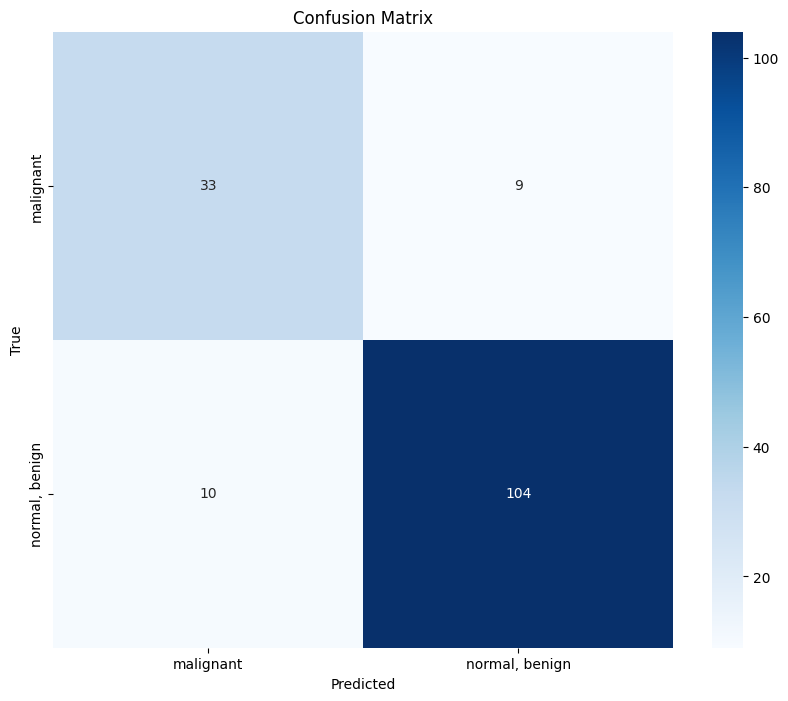

{'auc': np.float64(0.9189640768588136), 'accuracy': 0.8782051282051282, 'balanced_accuracy': np.float64(0.8489974937343359), 'sensitivity': 0.9122807017543859, 'specificity': np.float64(0.8489974937343359), 'confusion_matrix': array([[ 33,   9],
       [ 10, 104]])}
Ensemble AUC: 0.949, Ensemble Accuracy: 0.888


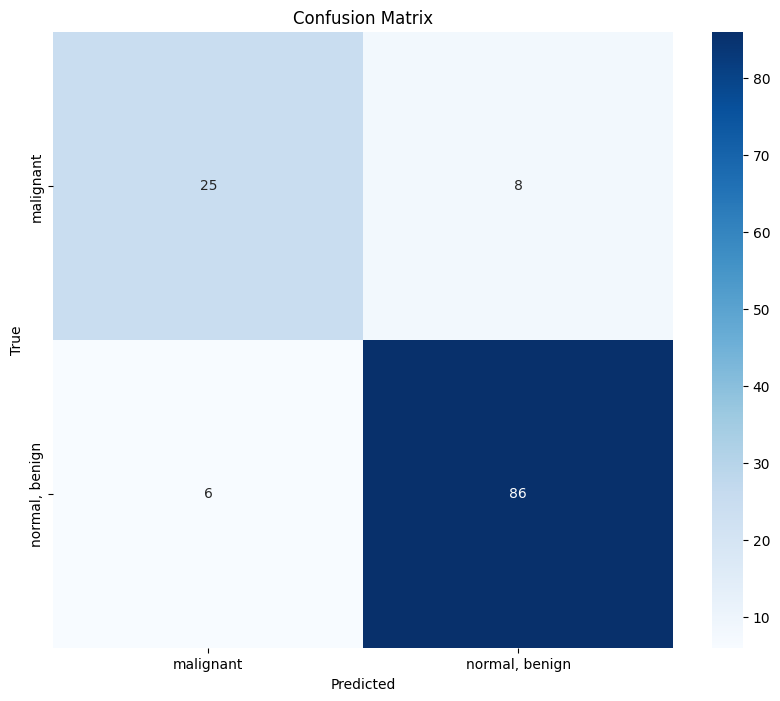

{'auc': np.float64(0.9486166007905138), 'accuracy': 0.888, 'balanced_accuracy': np.float64(0.8461791831357048), 'sensitivity': 0.9347826086956522, 'specificity': np.float64(0.8461791831357048), 'confusion_matrix': array([[25,  8],
       [ 6, 86]])}


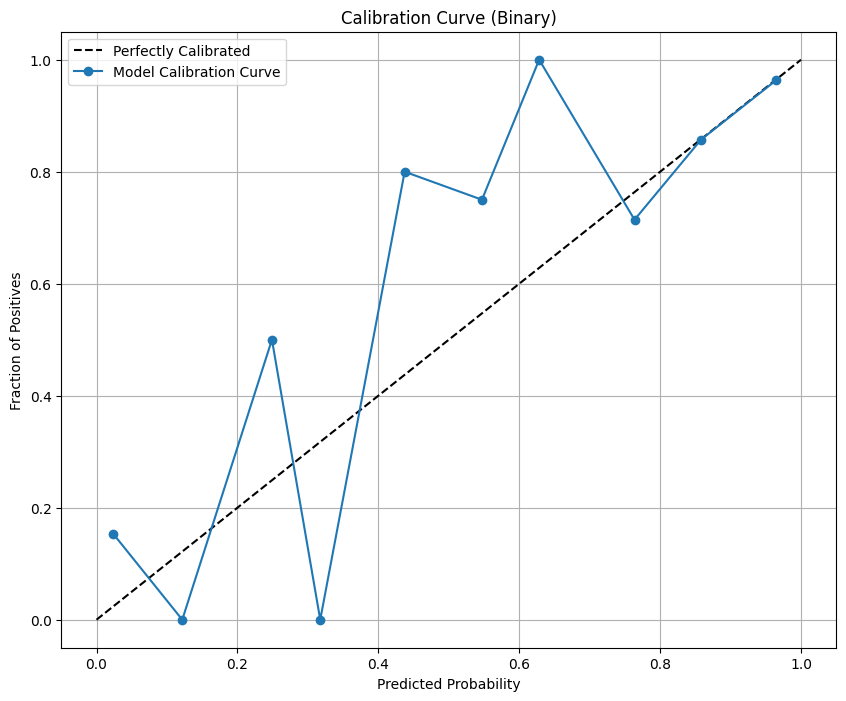

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:585: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


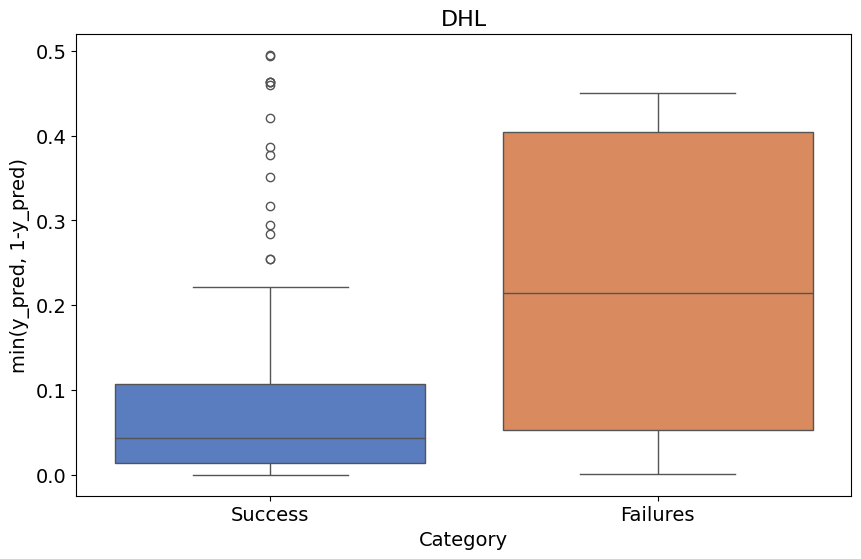

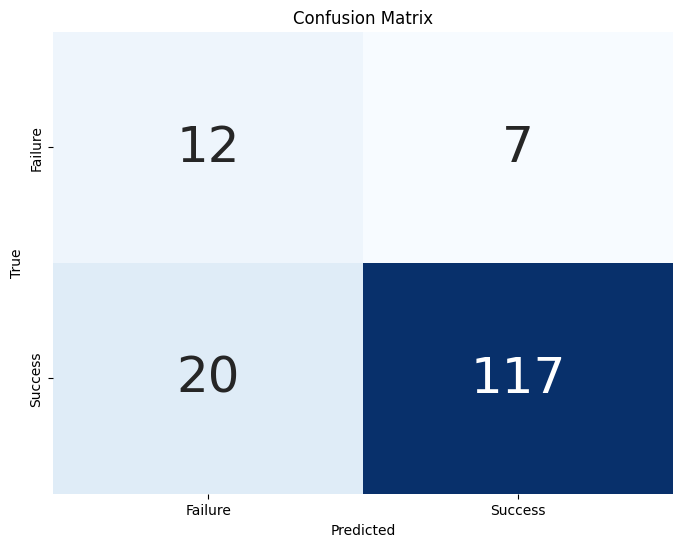

Optimal Threshold: 0.15674558281898499
Balanced Accuracy: 0.7427967729542835
Specificity: 0.631578947368421
Sensitivity: 0.8540145985401459
0.736073761044948
Brier Score Loss (platt): 0.1021


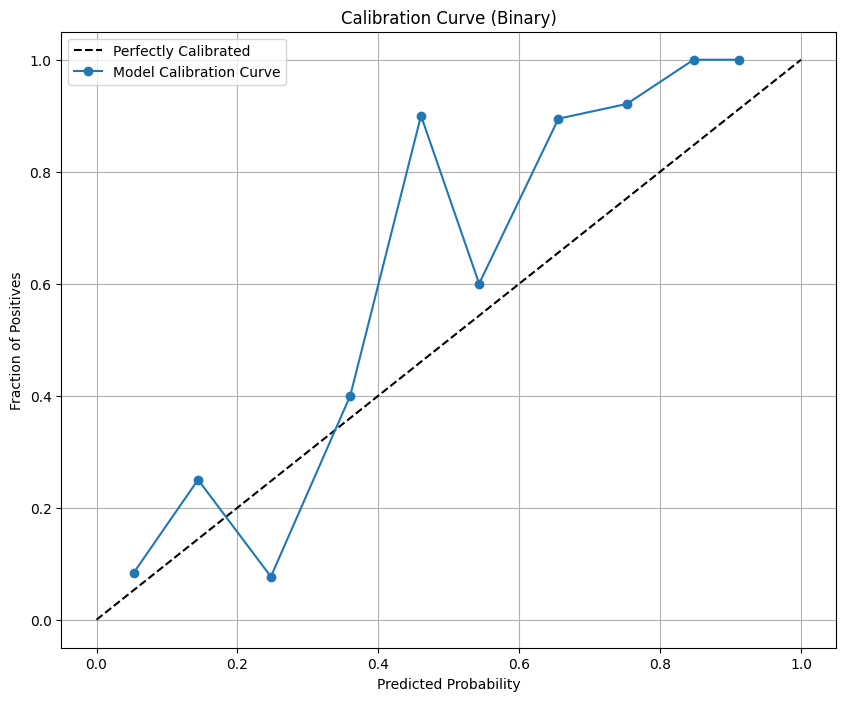

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:585: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


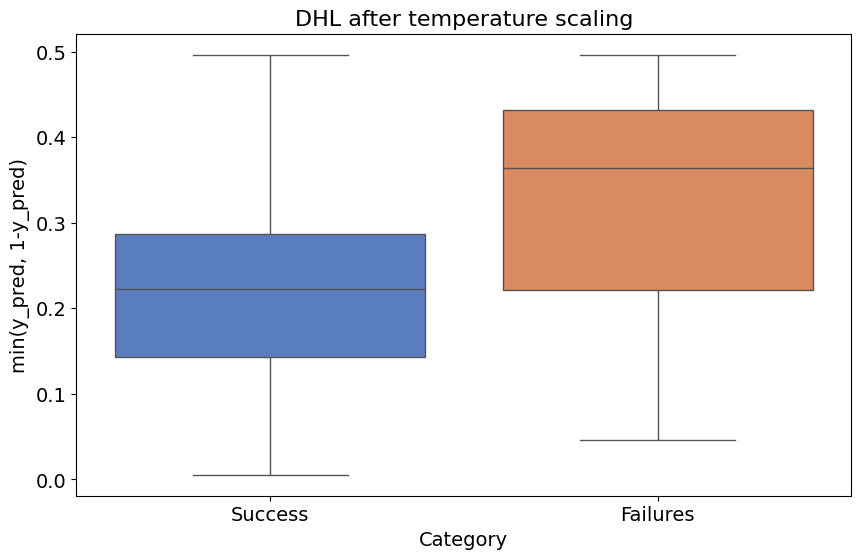

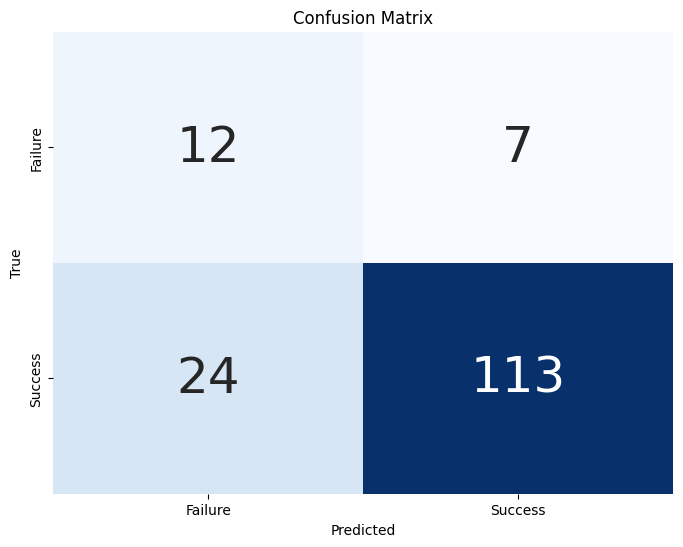

Optimal Threshold: 0.3333131905514407
Balanced Accuracy: 0.7281982328082981
Specificity: 0.631578947368421
Sensitivity: 0.8248175182481752
0.7199385324625431
Processing organamnist with color=False and activation=softmax
Training dataset size: 32841
Calibration dataset size: 8211
Training dataset size: 32841
Calibration dataset size: 8211


/tmp/ipykernel_3550362/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.999, Ensemble Accuracy: 0.977


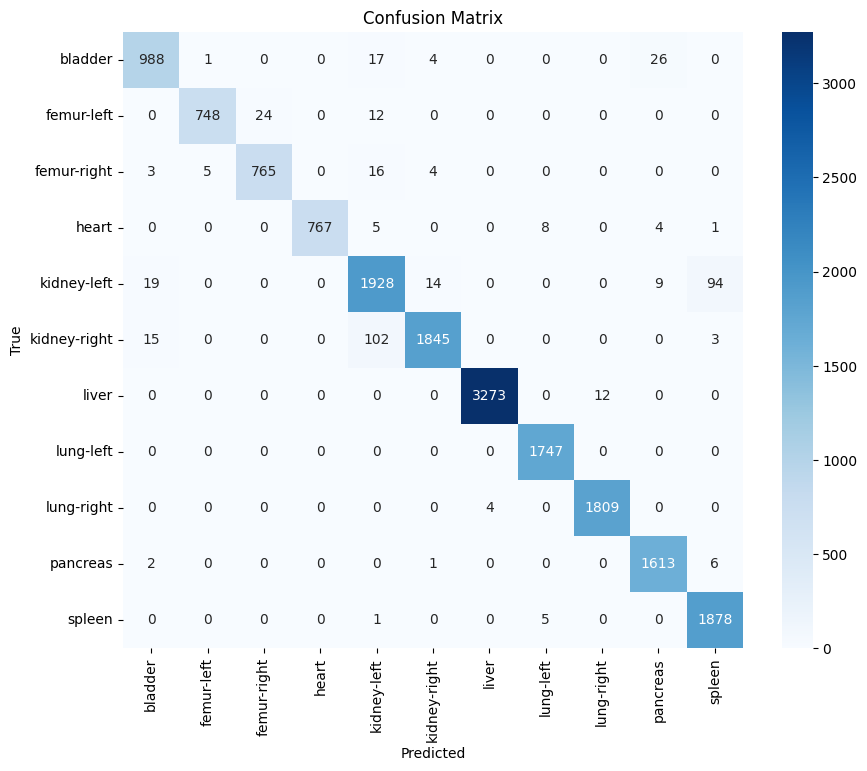

{'auc': np.float64(0.9994998659930716), 'accuracy': 0.97654404319946, 'balanced_accuracy': np.float64(0.9734507133527501), 'sensitivity': 0.9734507133527501, 'specificity': np.float64(0.9976288663557393), 'confusion_matrix': array([[ 988,    1,    0,    0,   17,    4,    0,    0,    0,   26,    0],
       [   0,  748,   24,    0,   12,    0,    0,    0,    0,    0,    0],
       [   3,    5,  765,    0,   16,    4,    0,    0,    0,    0,    0],
       [   0,    0,    0,  767,    5,    0,    0,    8,    0,    4,    1],
       [  19,    0,    0,    0, 1928,   14,    0,    0,    0,    9,   94],
       [  15,    0,    0,    0,  102, 1845,    0,    0,    0,    0,    3],
       [   0,    0,    0,    0,    0,    0, 3273,    0,   12,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 1747,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    4,    0, 1809,    0,    0],
       [   2,    0,    0,    0,    0,    1,    0,    0,    0, 1613,    6],
       [   0,    0,    0,

/tmp/ipykernel_3550362/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 1.000, Ensemble Accuracy: 0.999


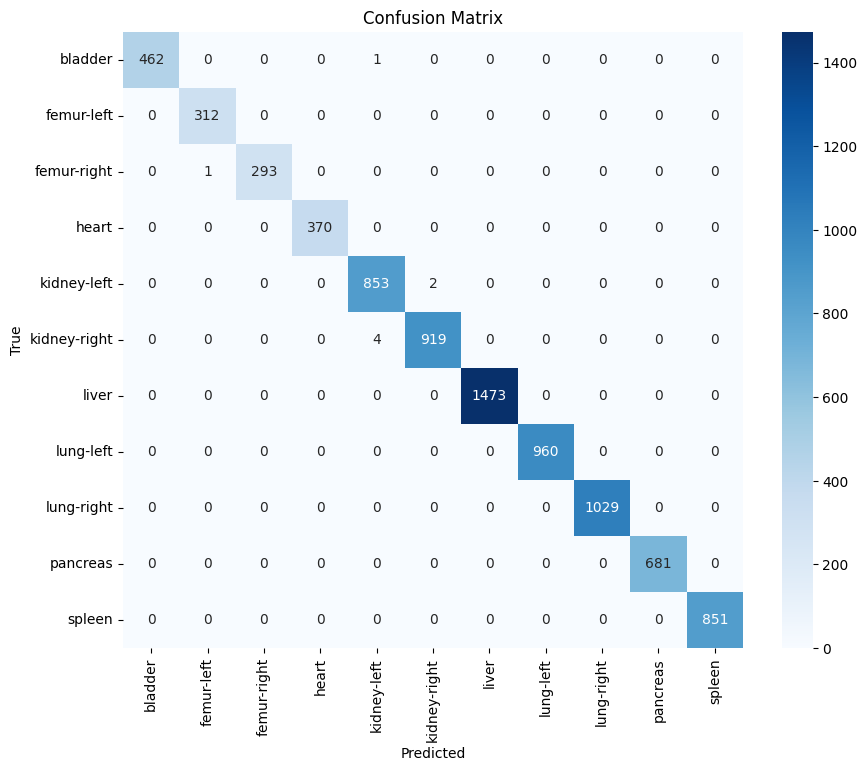

{'auc': np.float64(0.9999969500319612), 'accuracy': 0.9990256972354159, 'balanced_accuracy': np.float64(0.9988878124073518), 'sensitivity': 0.9988878124073518, 'specificity': np.float64(0.9999017509771435), 'confusion_matrix': array([[ 462,    0,    0,    0,    1,    0,    0,    0,    0,    0,    0],
       [   0,  312,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    1,  293,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,  370,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,  853,    2,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    4,  919,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 1473,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,  960,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 1029,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  681,    0],
       [   0,    0,    

/tmp/ipykernel_3550362/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


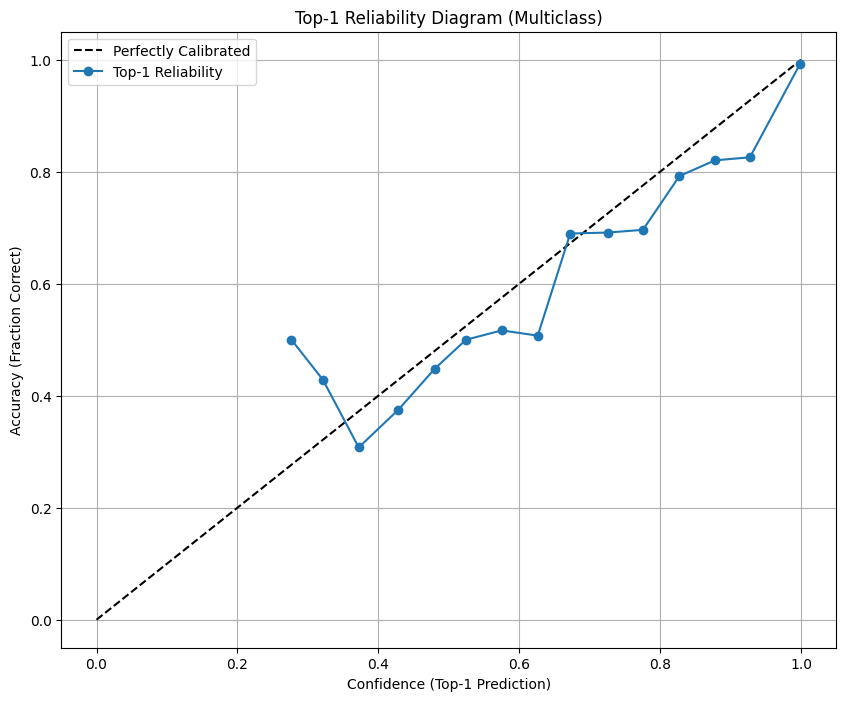

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:585: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


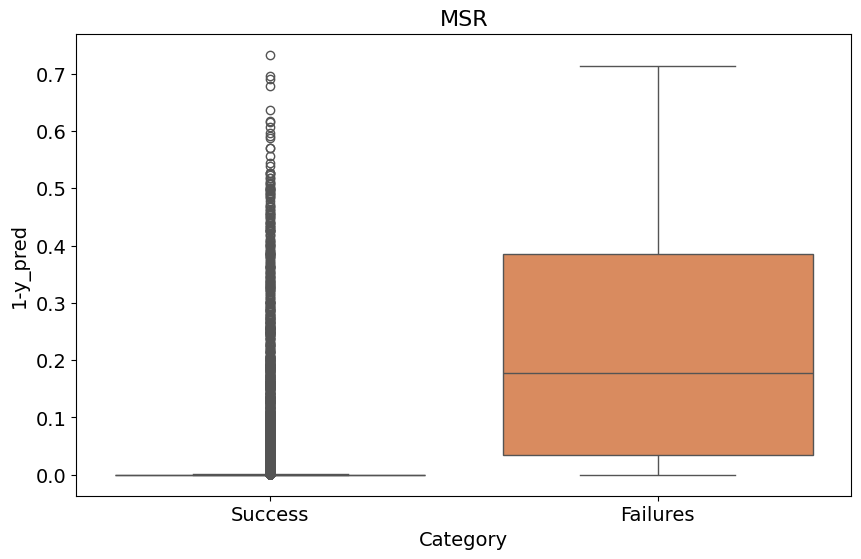

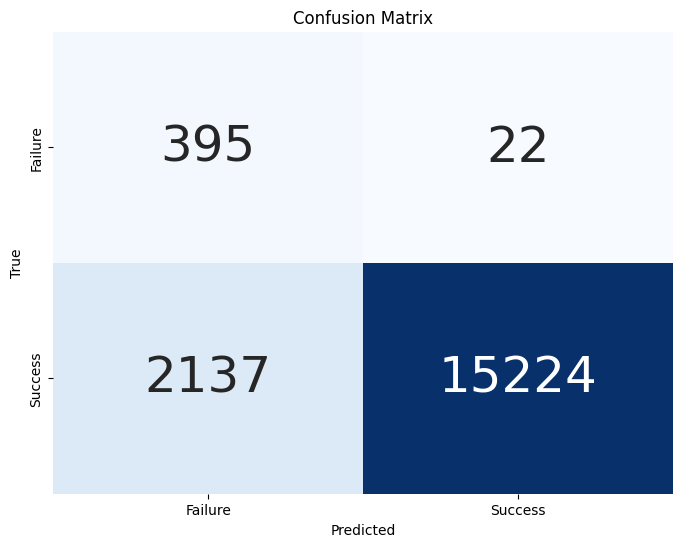

Optimal Threshold: 0.0022013813722878695
Balanced Accuracy: 0.912075109223145
Specificity: 0.947242206235012
Sensitivity: 0.8769080122112781
0.9637592846061841
Initial log-temperature: 0.4055
Initial temperature: 1.5000
Optimized log-temperature: 0.3881
Optimized temperature: 1.4741
Brier Score Loss (temperature): 0.0007


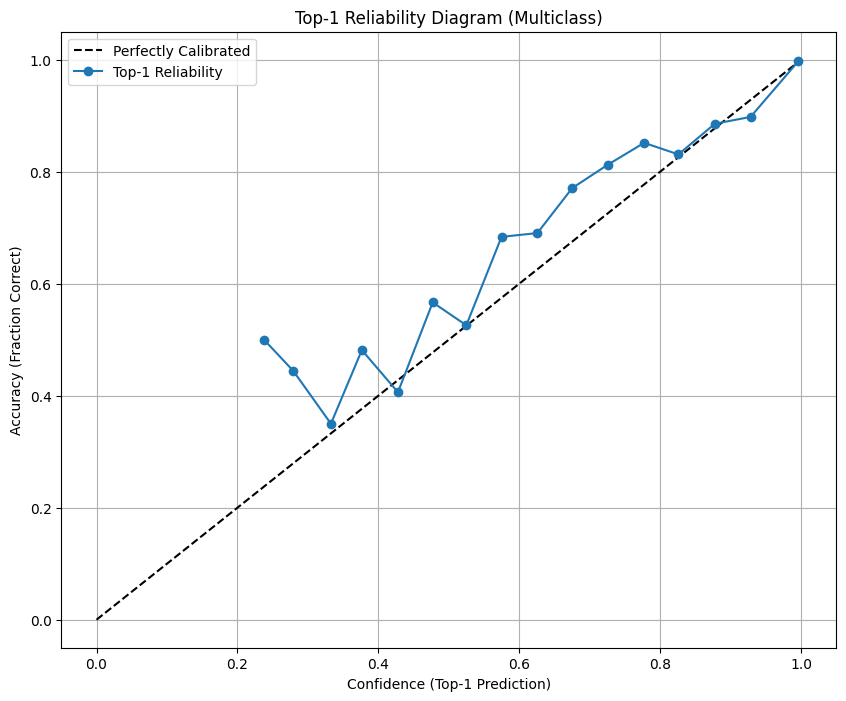

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:585: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


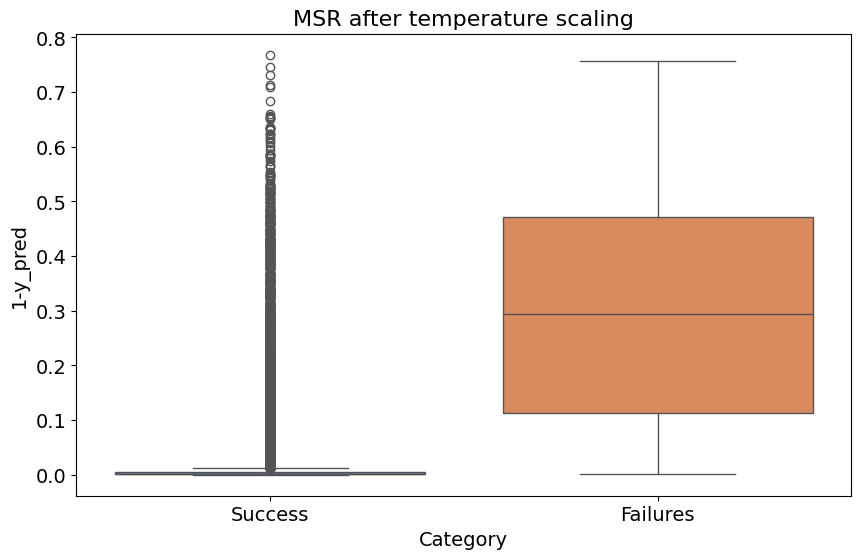

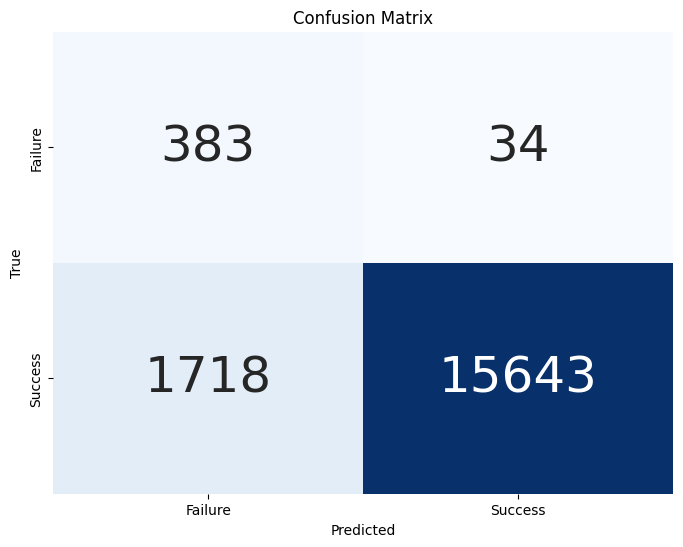

Optimal Threshold: 0.033841028809547424
Balanced Accuracy: 0.9097538972450863
Specificity: 0.9184652278177458
Sensitivity: 0.9010425666724267
0.9603385547998443
Processing pneumoniamnist with color=False and activation=sigmoid
Training dataset size: 4185
Calibration dataset size: 1047
Training dataset size: 4185
Calibration dataset size: 1047
Ensemble AUC: 0.990, Ensemble Accuracy: 0.920


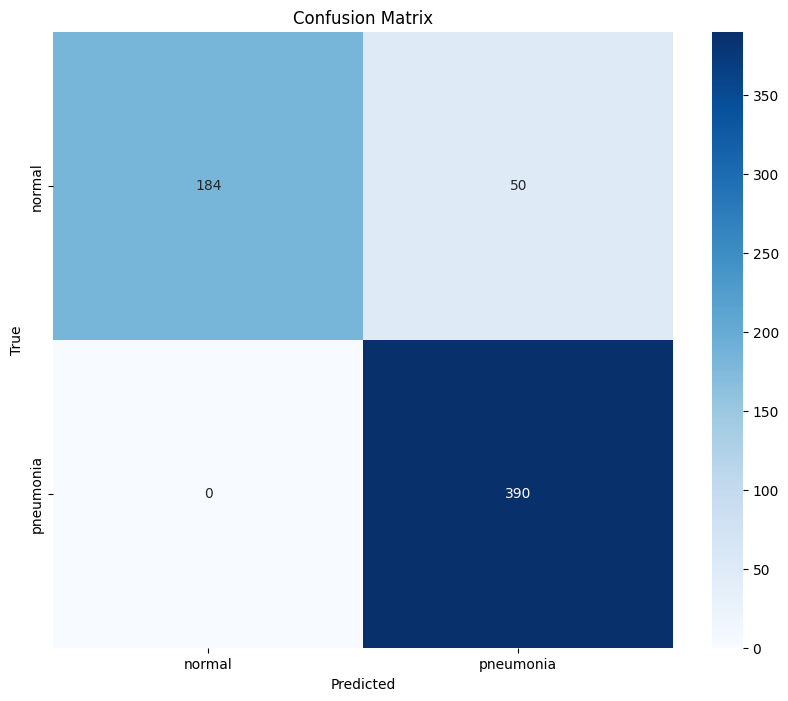

{'auc': np.float64(0.989831251369713), 'accuracy': 0.9198717948717948, 'balanced_accuracy': np.float64(0.8931623931623931), 'sensitivity': 1.0, 'specificity': np.float64(0.8931623931623931), 'confusion_matrix': array([[184,  50],
       [  0, 390]])}
Ensemble AUC: 0.999, Ensemble Accuracy: 0.989


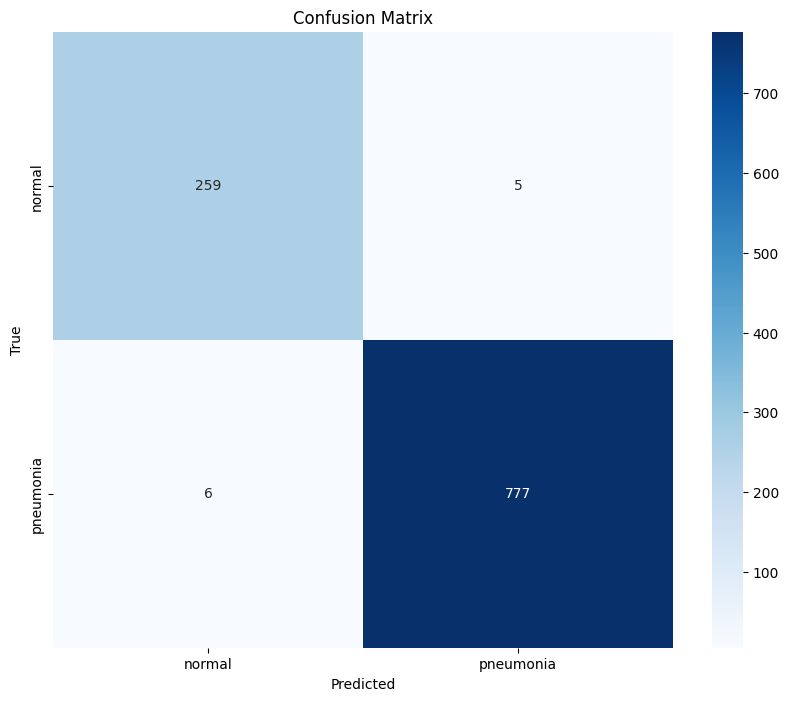

{'auc': np.float64(0.9987373737373737), 'accuracy': 0.9894937917860553, 'balanced_accuracy': np.float64(0.986698885405782), 'sensitivity': 0.9923371647509579, 'specificity': np.float64(0.986698885405782), 'confusion_matrix': array([[259,   5],
       [  6, 777]])}


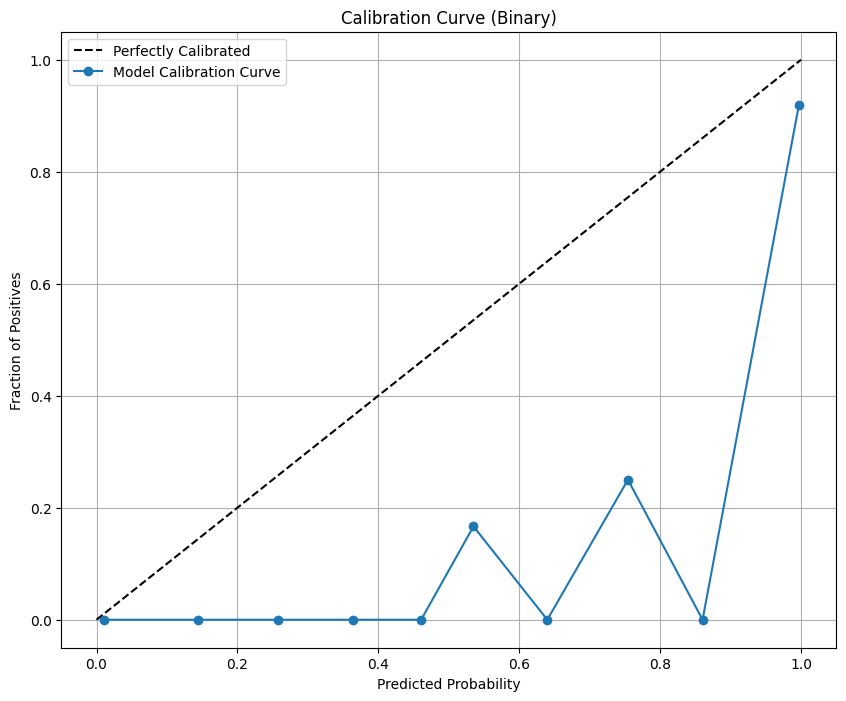

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:585: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


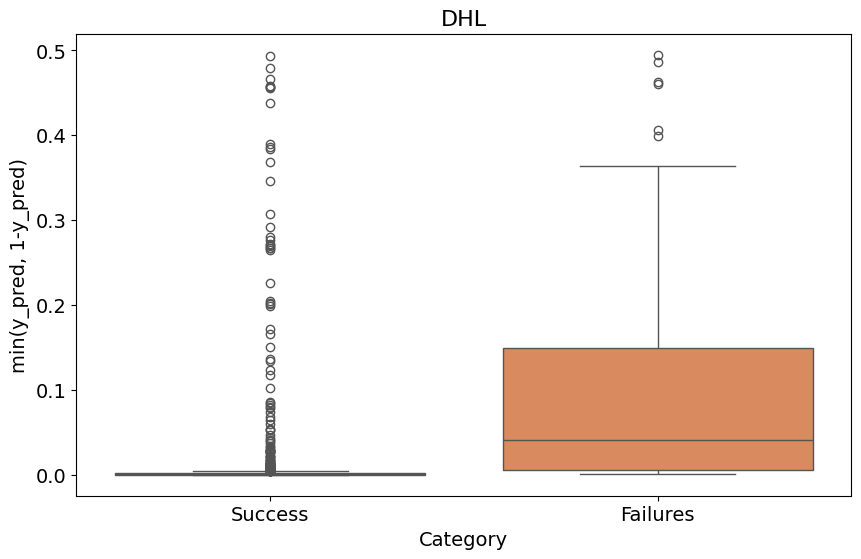

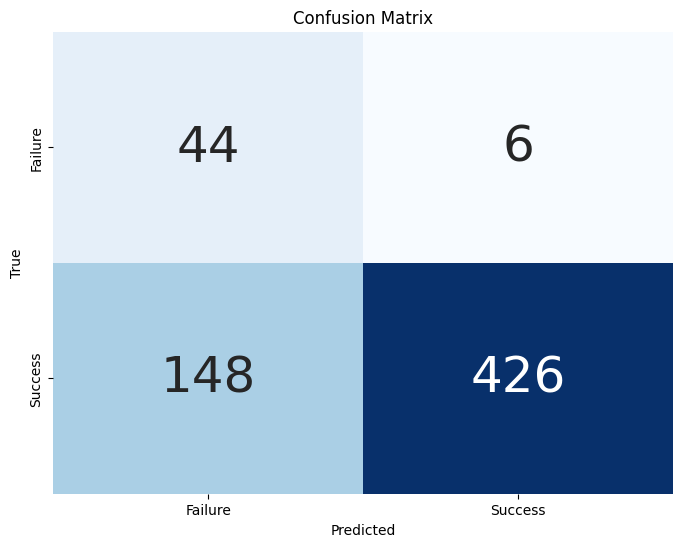

Optimal Threshold: 0.0014862369280308485
Balanced Accuracy: 0.8110801393728223
Specificity: 0.88
Sensitivity: 0.7421602787456446
0.8750871080139373
Brier Score Loss (platt): 0.0096


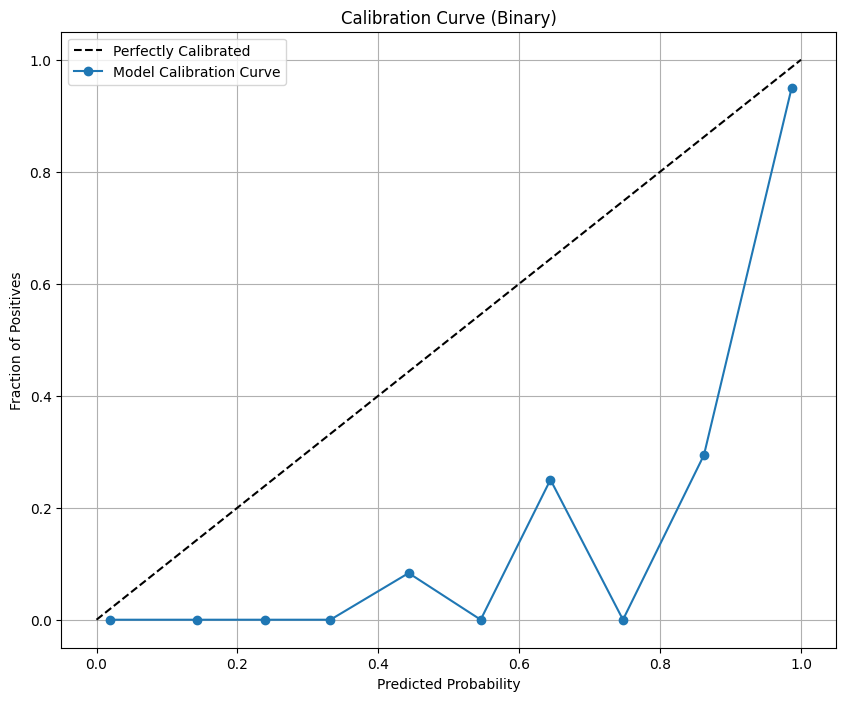

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:585: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


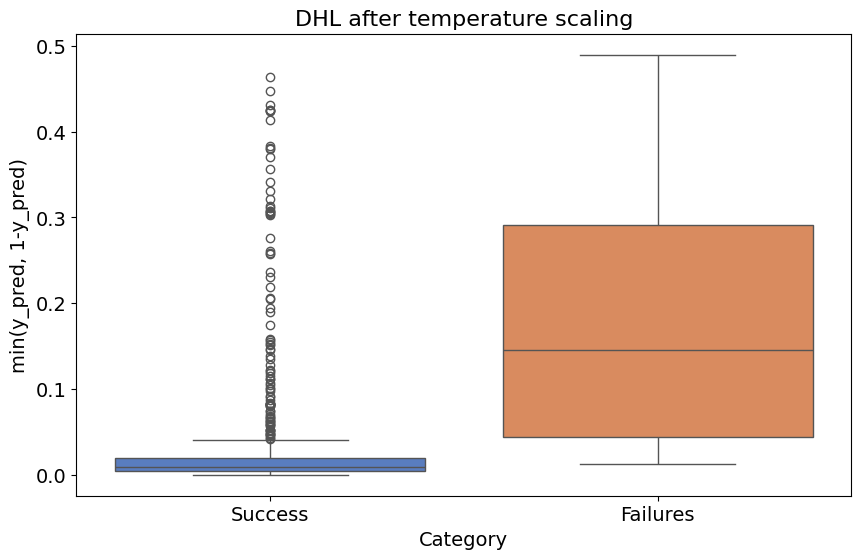

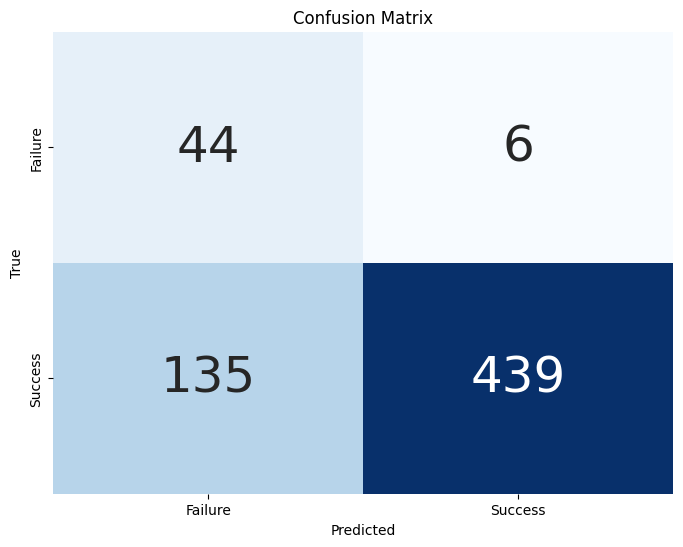

Optimal Threshold: 0.021573023034662468
Balanced Accuracy: 0.822404181184669
Specificity: 0.88
Sensitivity: 0.764808362369338
0.8893728222996516
Processing dermamnist with color=True and activation=softmax
Training dataset size: 6408
Calibration dataset size: 1602
Training dataset size: 6408
Calibration dataset size: 1602


/tmp/ipykernel_3550362/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.974, Ensemble Accuracy: 0.866


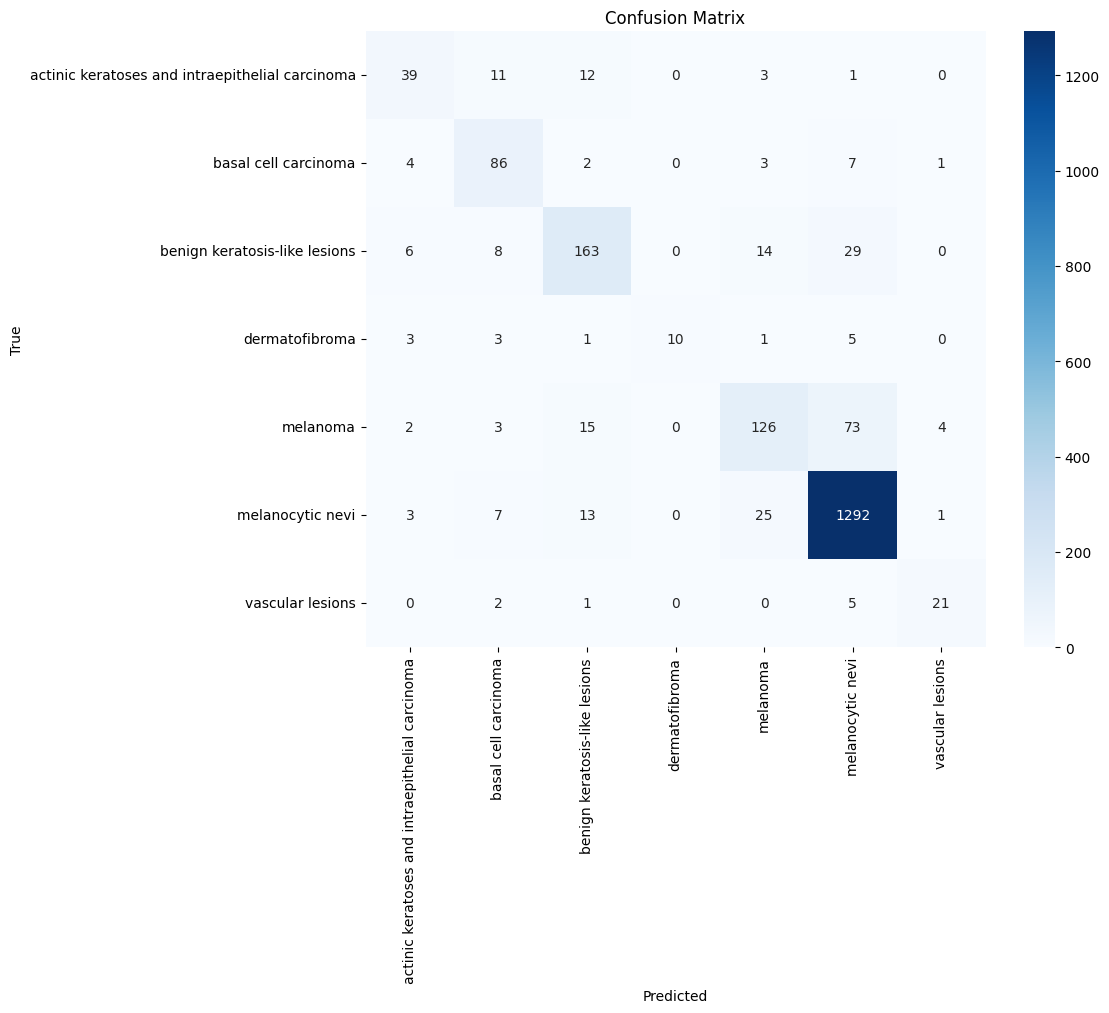

{'auc': np.float64(0.9736996347569223), 'accuracy': 0.8663341645885286, 'balanced_accuracy': np.float64(0.693453243397623), 'sensitivity': 0.693453243397623, 'specificity': np.float64(0.9626597232916266), 'confusion_matrix': array([[  39,   11,   12,    0,    3,    1,    0],
       [   4,   86,    2,    0,    3,    7,    1],
       [   6,    8,  163,    0,   14,   29,    0],
       [   3,    3,    1,   10,    1,    5,    0],
       [   2,    3,   15,    0,  126,   73,    4],
       [   3,    7,   13,    0,   25, 1292,    1],
       [   0,    2,    1,    0,    0,    5,   21]])}


/tmp/ipykernel_3550362/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.970, Ensemble Accuracy: 0.859


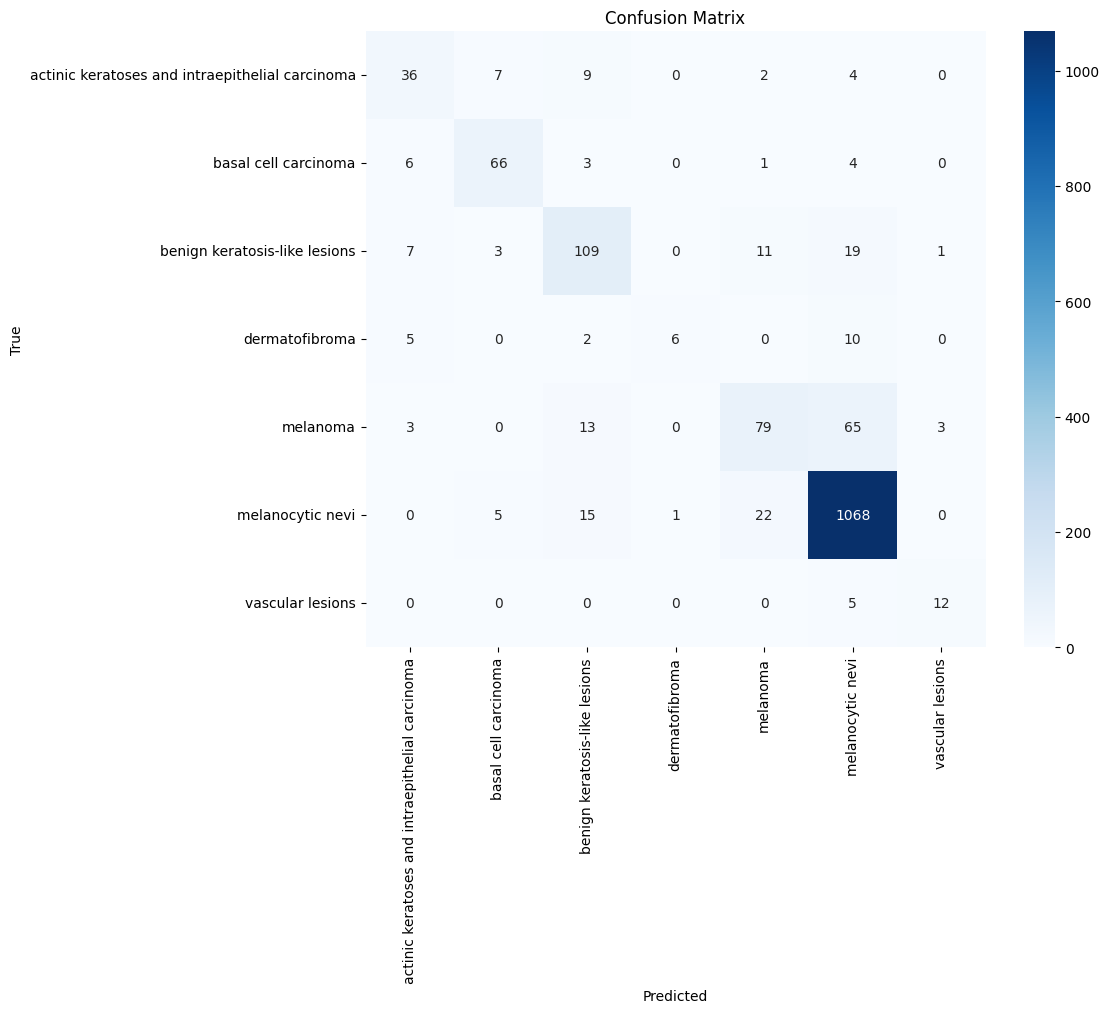

{'auc': np.float64(0.9704562844422462), 'accuracy': 0.8589263420724095, 'balanced_accuracy': np.float64(0.655009563756818), 'sensitivity': 0.655009563756818, 'specificity': np.float64(0.9573601341308037), 'confusion_matrix': array([[  36,    7,    9,    0,    2,    4,    0],
       [   6,   66,    3,    0,    1,    4,    0],
       [   7,    3,  109,    0,   11,   19,    1],
       [   5,    0,    2,    6,    0,   10,    0],
       [   3,    0,   13,    0,   79,   65,    3],
       [   0,    5,   15,    1,   22, 1068,    0],
       [   0,    0,    0,    0,    0,    5,   12]])}


/tmp/ipykernel_3550362/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


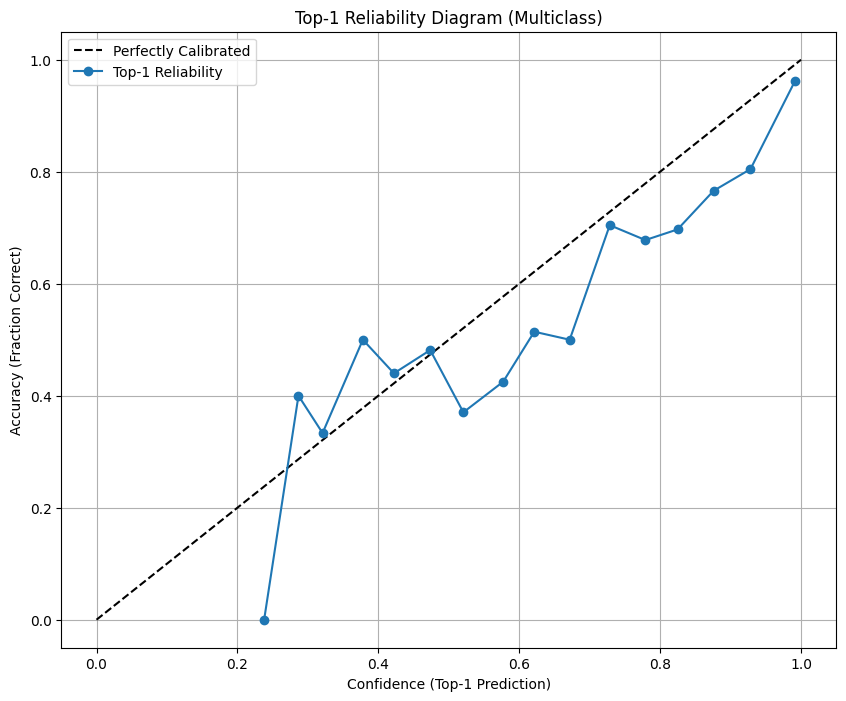

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:585: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


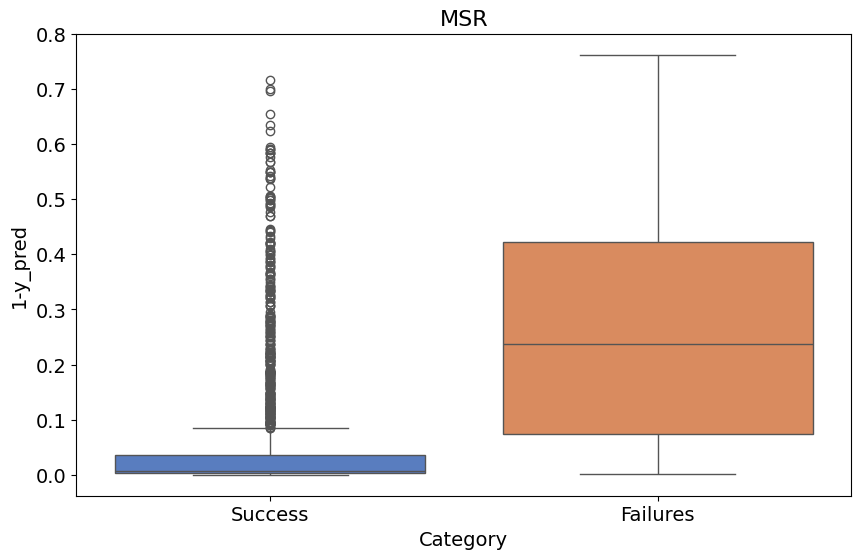

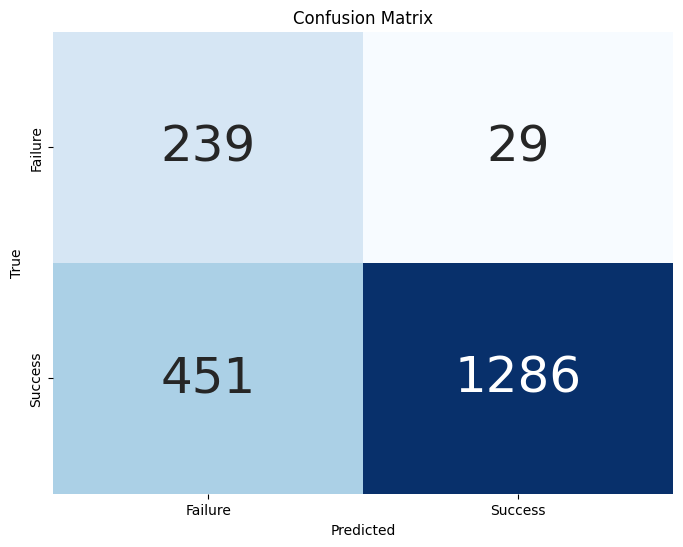

Optimal Threshold: 0.029776494950056076
Balanced Accuracy: 0.8160739910121242
Specificity: 0.8917910447761194
Sensitivity: 0.740356937248129
0.8746058137636517
Initial log-temperature: 0.4055
Initial temperature: 1.5000
Optimized log-temperature: 0.4721
Optimized temperature: 1.6034
Brier Score Loss (temperature): 0.0403


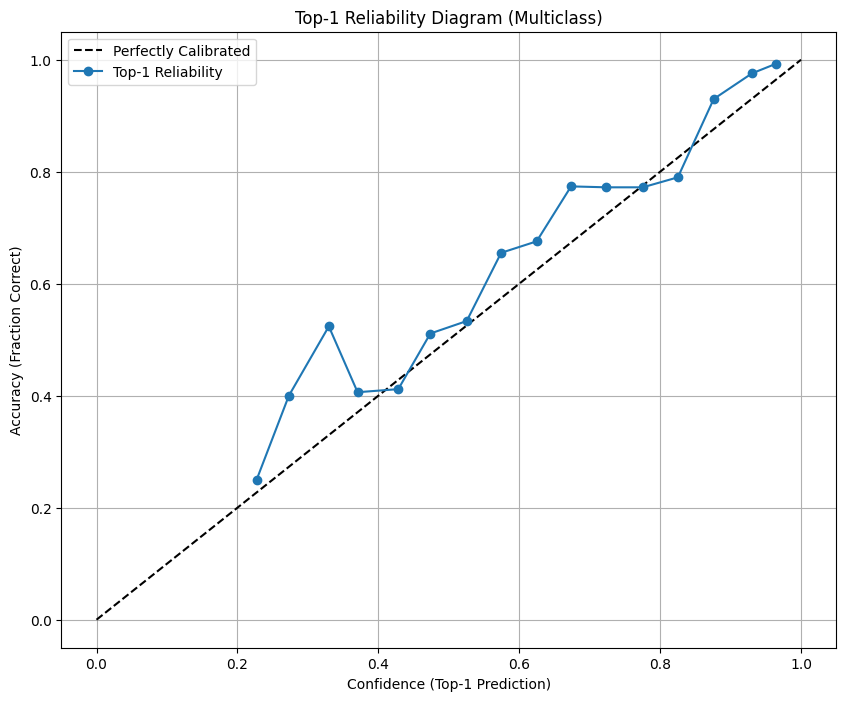

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:585: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


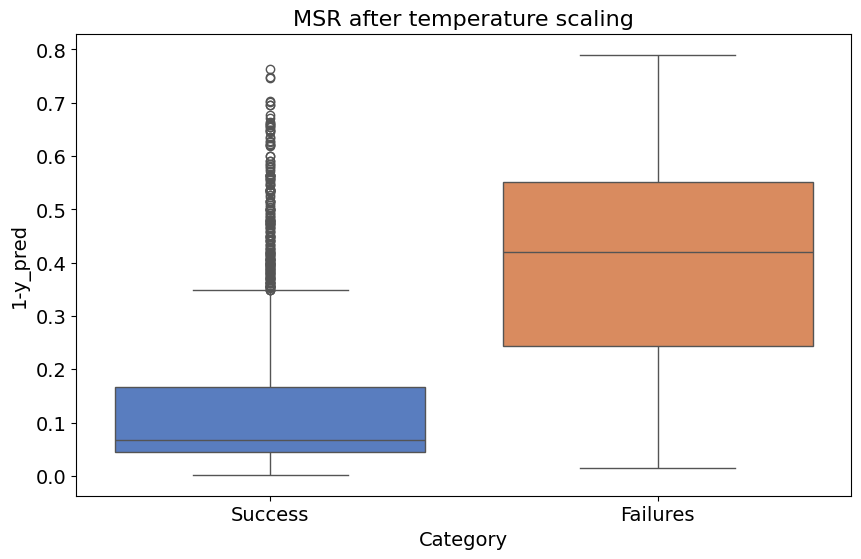

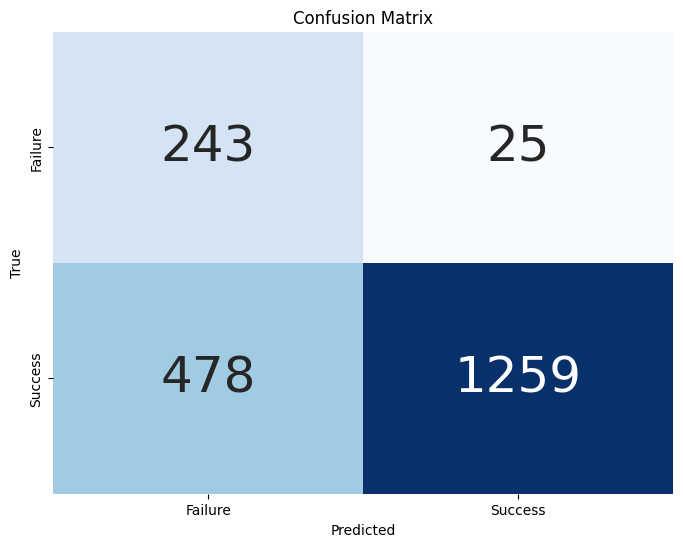

Optimal Threshold: 0.1426677256822586
Balanced Accuracy: 0.8157646568538998
Specificity: 0.9067164179104478
Sensitivity: 0.7248128957973518
0.8719141769563237
Processing octmnist with color=False and activation=softmax
Training dataset size: 86647
Calibration dataset size: 21662
Training dataset size: 86647
Calibration dataset size: 21662


/tmp/ipykernel_3550362/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.989, Ensemble Accuracy: 0.828


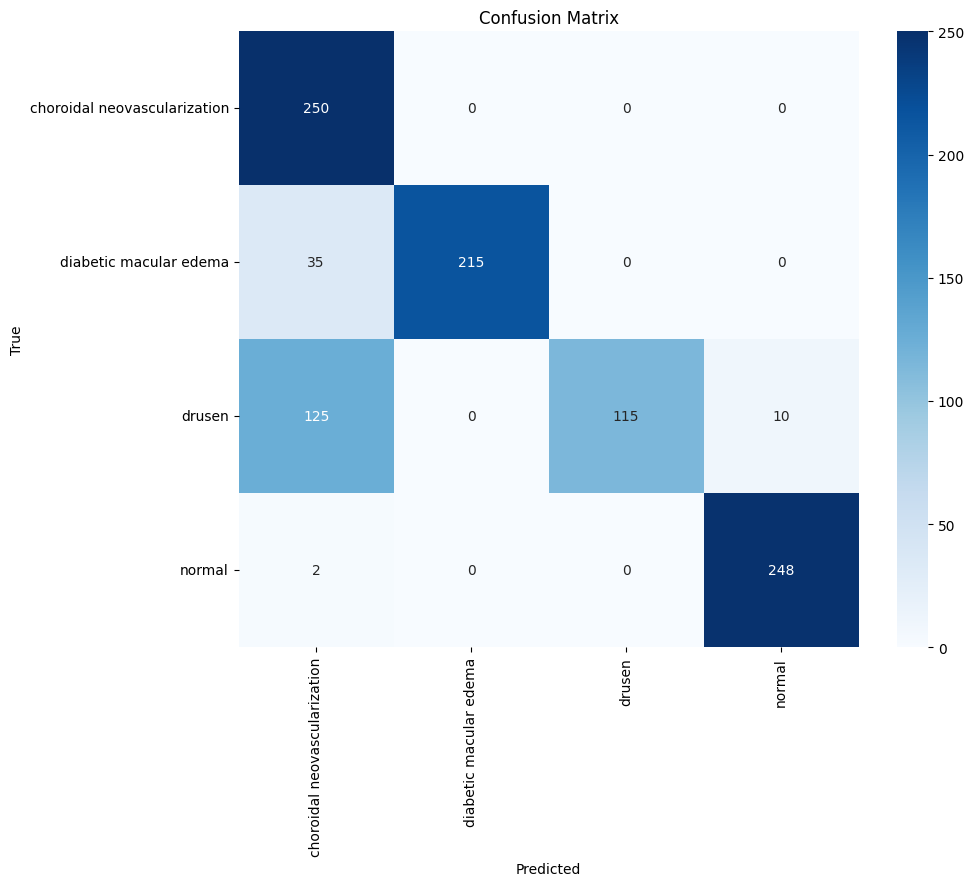

{'auc': np.float64(0.9894253333333334), 'accuracy': 0.828, 'balanced_accuracy': np.float64(0.828), 'sensitivity': 0.828, 'specificity': np.float64(0.9426666666666667), 'confusion_matrix': array([[250,   0,   0,   0],
       [ 35, 215,   0,   0],
       [125,   0, 115,  10],
       [  2,   0,   0, 248]])}


/tmp/ipykernel_3550362/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.998, Ensemble Accuracy: 0.978


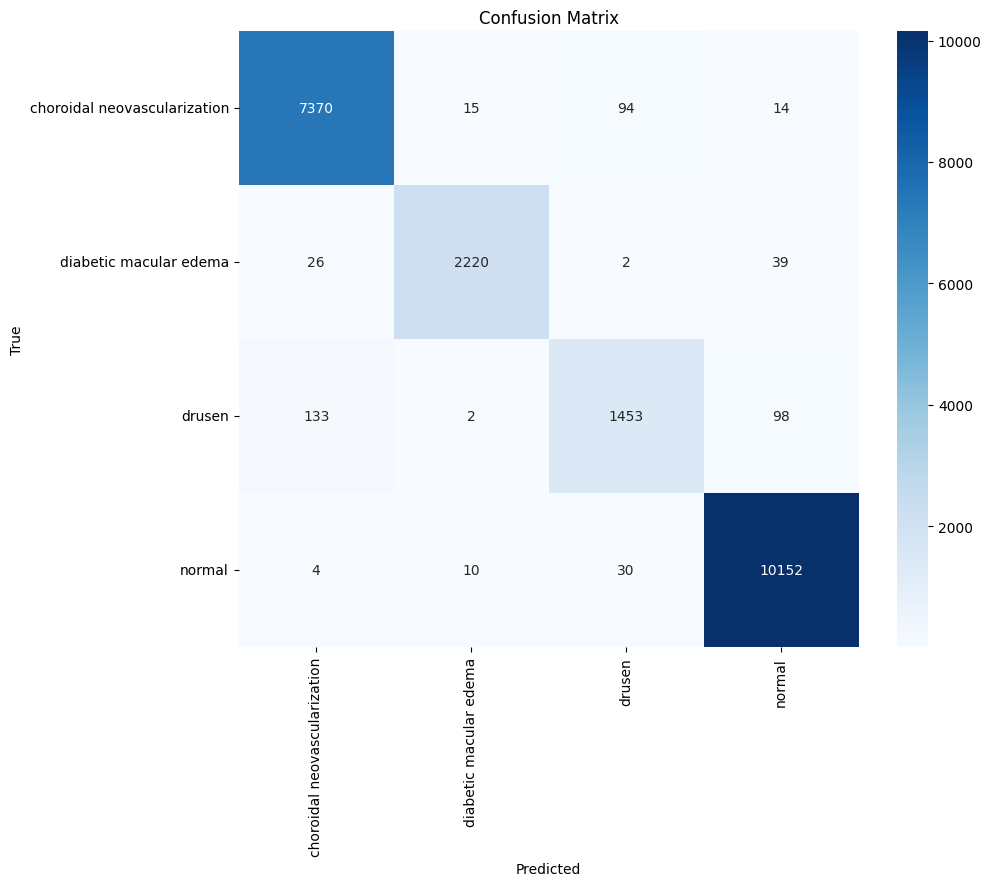

{'auc': np.float64(0.9977831311910828), 'accuracy': 0.9784415104791802, 'balanced_accuracy': np.float64(0.9529440811144193), 'sensitivity': 0.9529440811144193, 'specificity': np.float64(0.9919063811598149), 'confusion_matrix': array([[ 7370,    15,    94,    14],
       [   26,  2220,     2,    39],
       [  133,     2,  1453,    98],
       [    4,    10,    30, 10152]])}


/tmp/ipykernel_3550362/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


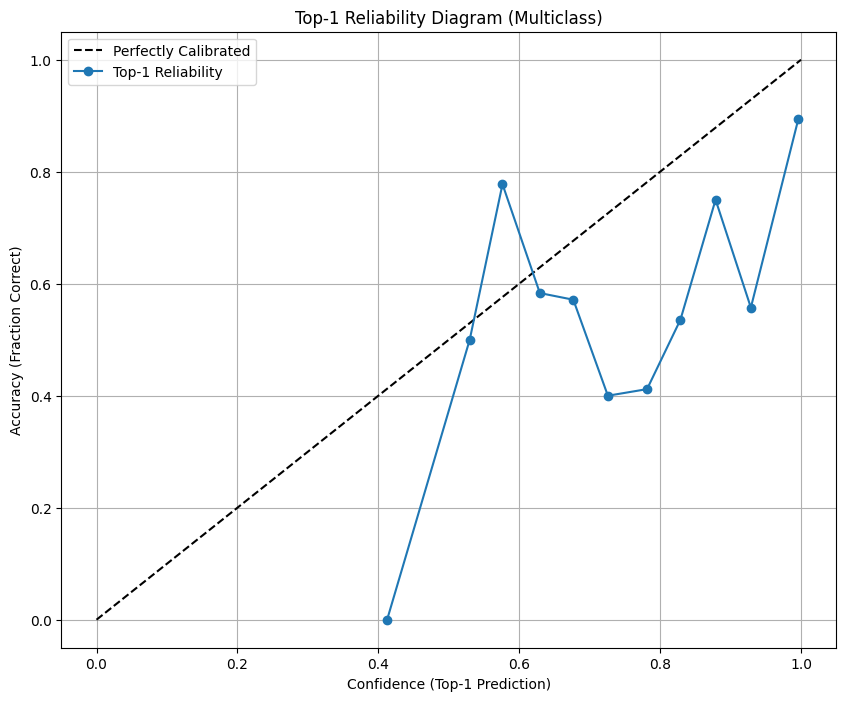

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:585: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


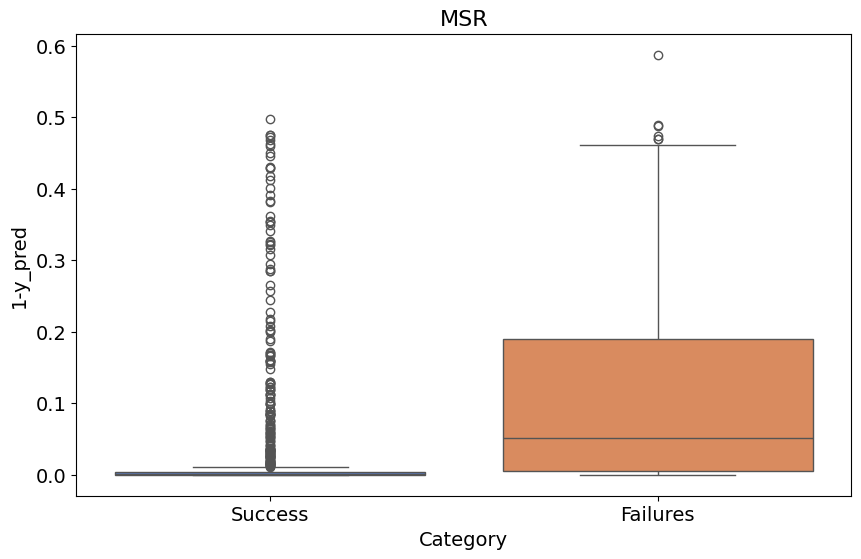

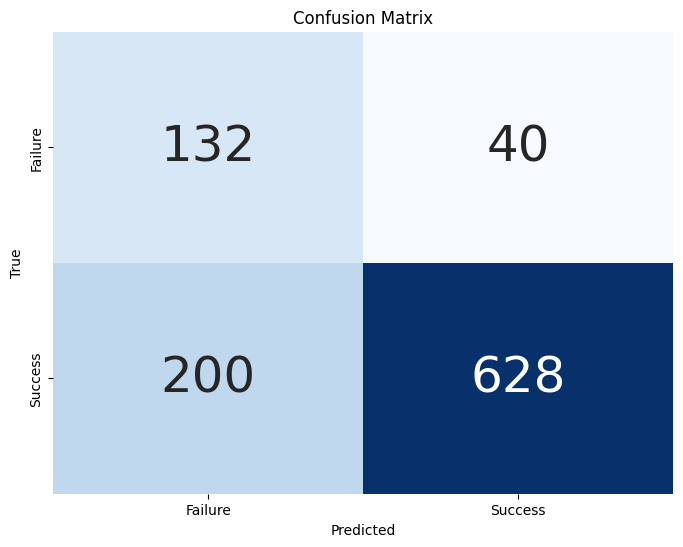

Optimal Threshold: 0.004705123603343964
Balanced Accuracy: 0.7629479833726548
Specificity: 0.7674418604651163
Sensitivity: 0.7584541062801933
0.8127246938546231
Initial log-temperature: 0.4055
Initial temperature: 1.5000
Optimized log-temperature: 0.4758
Optimized temperature: 1.6093
Brier Score Loss (temperature): 0.0043


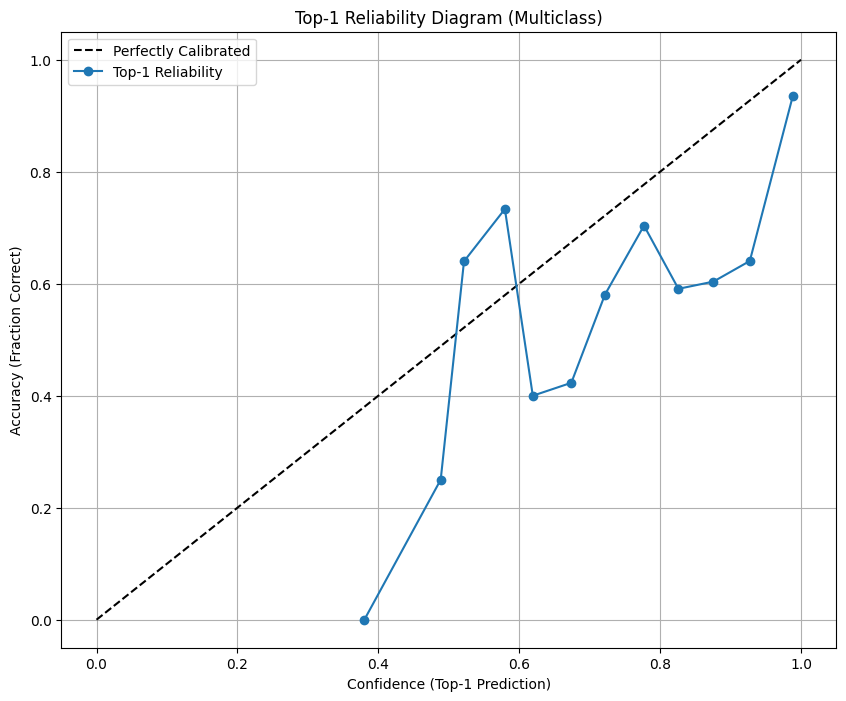

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:585: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


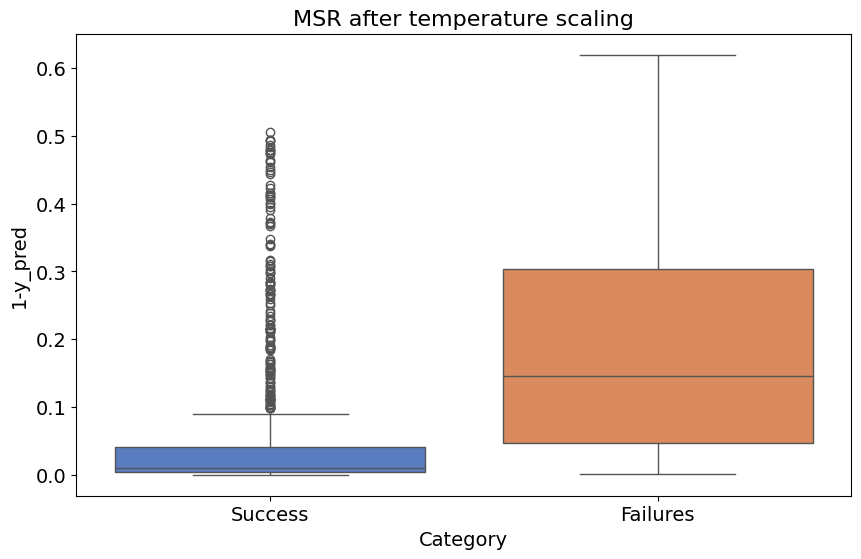

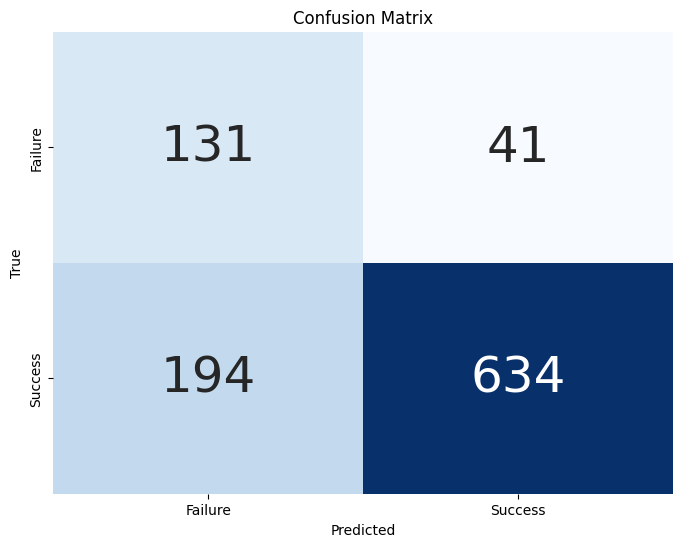

Optimal Threshold: 0.04411172494292259
Balanced Accuracy: 0.7636641950342657
Specificity: 0.7616279069767442
Sensitivity: 0.7657004830917874
0.8100915627457588
Processing pathmnist with color=True and activation=softmax
Training dataset size: 80000
Calibration dataset size: 20000
Training dataset size: 80000
Calibration dataset size: 20000


/tmp/ipykernel_3550362/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.993, Ensemble Accuracy: 0.959


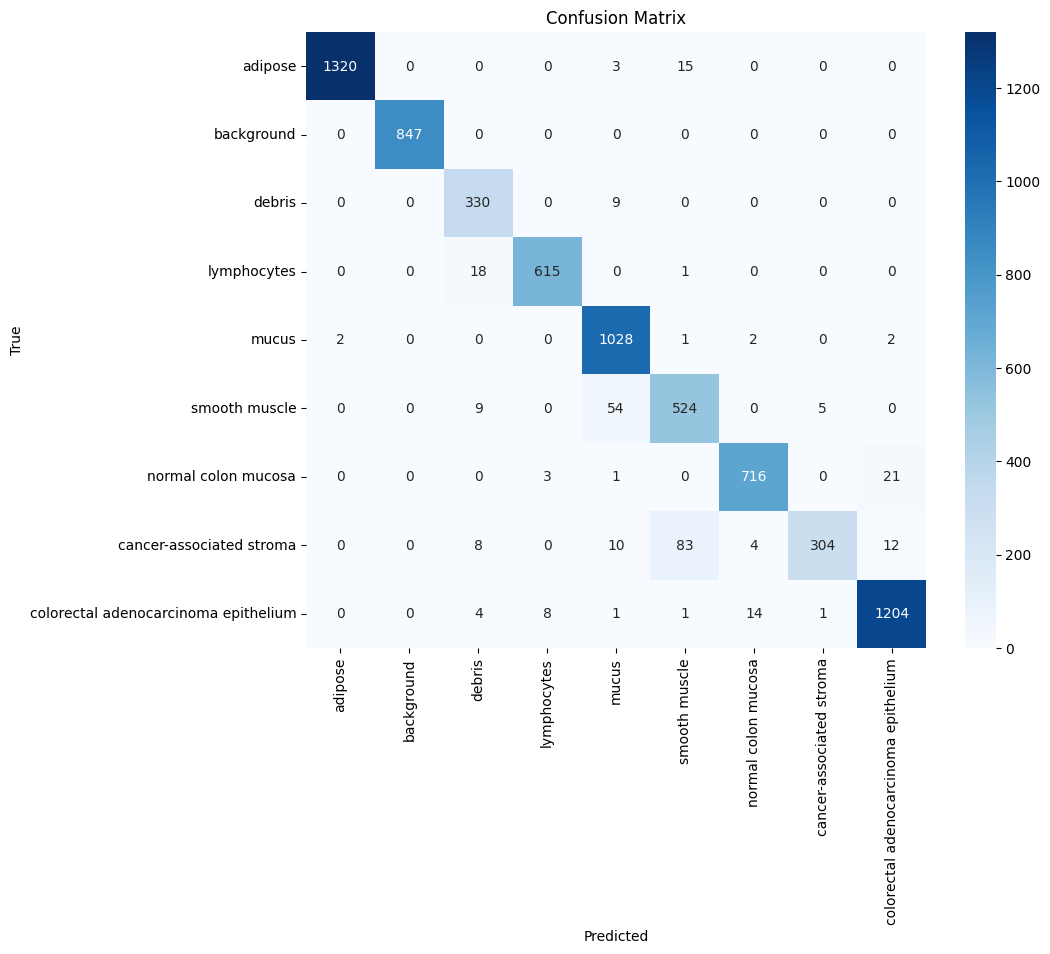

{'auc': np.float64(0.9925181675071182), 'accuracy': 0.9593314763231198, 'balanced_accuracy': np.float64(0.9414704453224735), 'sensitivity': 0.9414704453224735, 'specificity': np.float64(0.9949303406500347), 'confusion_matrix': array([[1320,    0,    0,    0,    3,   15,    0,    0,    0],
       [   0,  847,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,  330,    0,    9,    0,    0,    0,    0],
       [   0,    0,   18,  615,    0,    1,    0,    0,    0],
       [   2,    0,    0,    0, 1028,    1,    2,    0,    2],
       [   0,    0,    9,    0,   54,  524,    0,    5,    0],
       [   0,    0,    0,    3,    1,    0,  716,    0,   21],
       [   0,    0,    8,    0,   10,   83,    4,  304,   12],
       [   0,    0,    4,    8,    1,    1,   14,    1, 1204]])}


/tmp/ipykernel_3550362/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 1.000, Ensemble Accuracy: 0.996


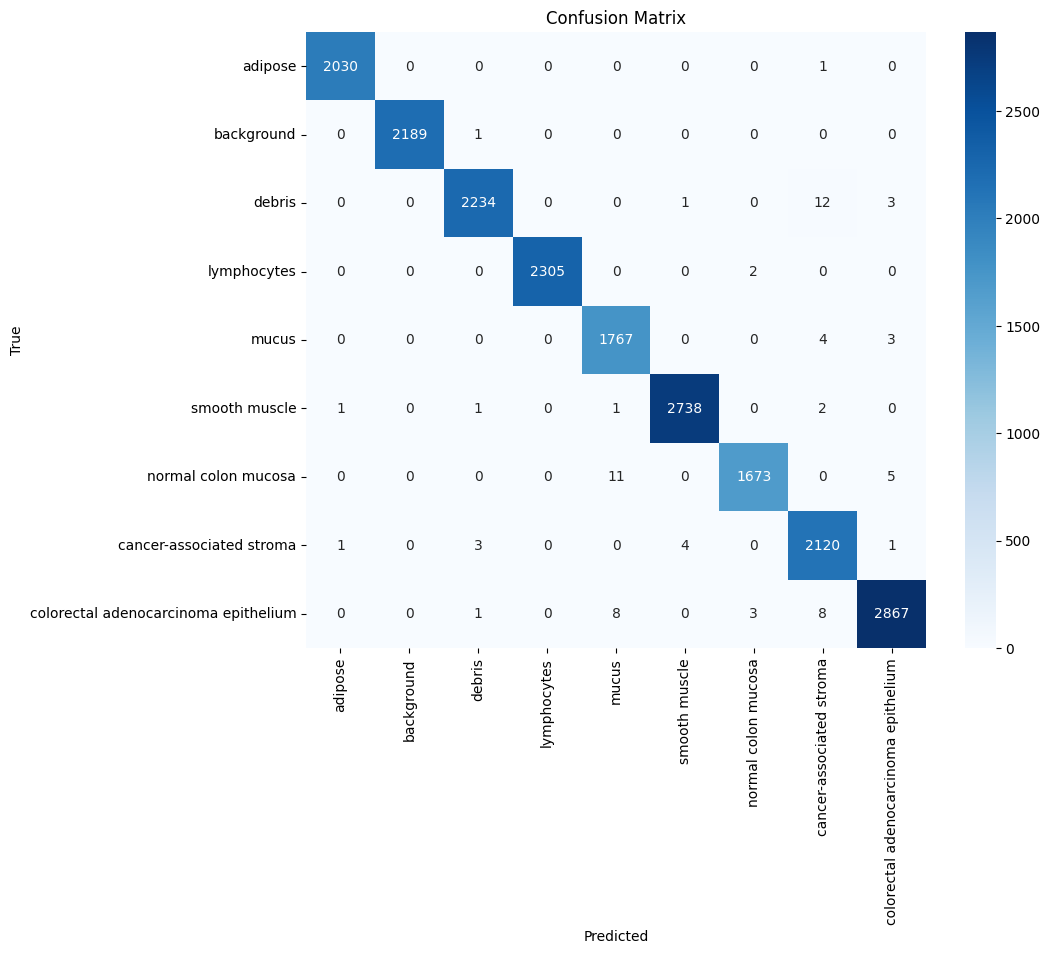

{'auc': np.float64(0.9999795877649343), 'accuracy': 0.99615, 'balanced_accuracy': np.float64(0.996075140204652), 'sensitivity': 0.996075140204652, 'specificity': np.float64(0.9995198321392631), 'confusion_matrix': array([[2030,    0,    0,    0,    0,    0,    0,    1,    0],
       [   0, 2189,    1,    0,    0,    0,    0,    0,    0],
       [   0,    0, 2234,    0,    0,    1,    0,   12,    3],
       [   0,    0,    0, 2305,    0,    0,    2,    0,    0],
       [   0,    0,    0,    0, 1767,    0,    0,    4,    3],
       [   1,    0,    1,    0,    1, 2738,    0,    2,    0],
       [   0,    0,    0,    0,   11,    0, 1673,    0,    5],
       [   1,    0,    3,    0,    0,    4,    0, 2120,    1],
       [   0,    0,    1,    0,    8,    0,    3,    8, 2867]])}


/tmp/ipykernel_3550362/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


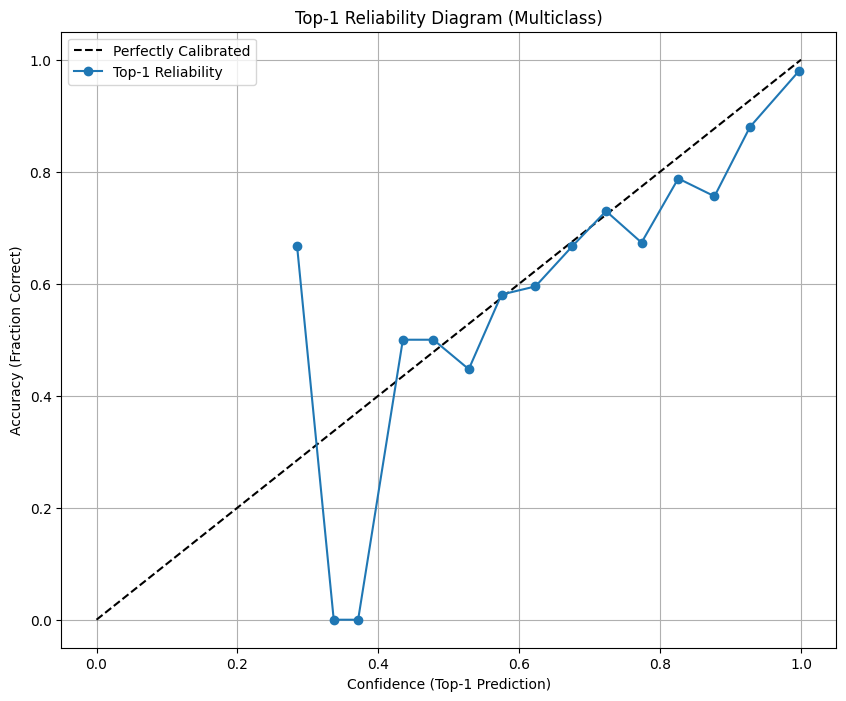

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:585: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


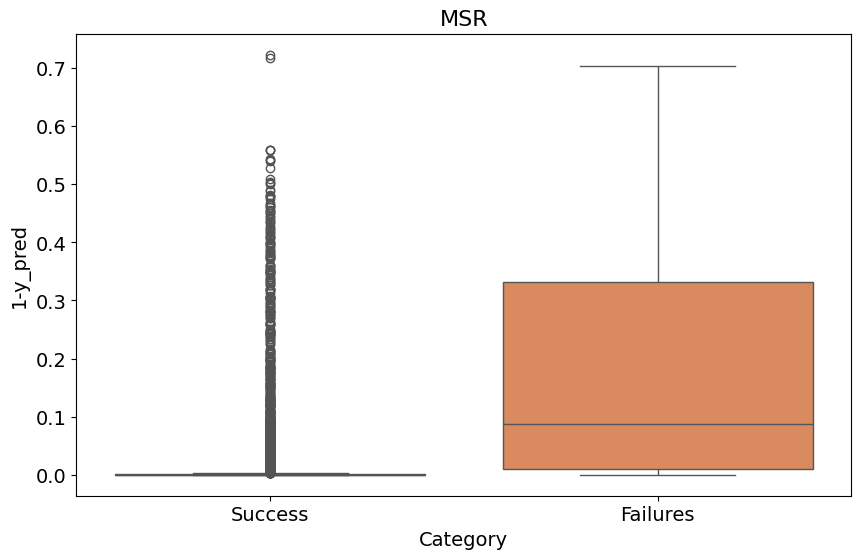

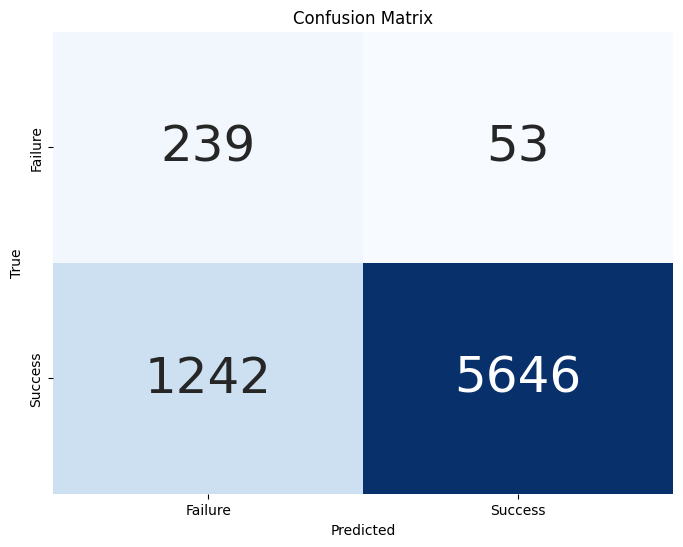

Optimal Threshold: 0.0036193905398249626
Balanced Accuracy: 0.8190897809173787
Specificity: 0.8184931506849316
Sensitivity: 0.8196864111498258
0.8734731237967958
Initial log-temperature: 0.4055
Initial temperature: 1.5000
Optimized log-temperature: 0.2421
Optimized temperature: 1.2739
Brier Score Loss (temperature): 0.0012


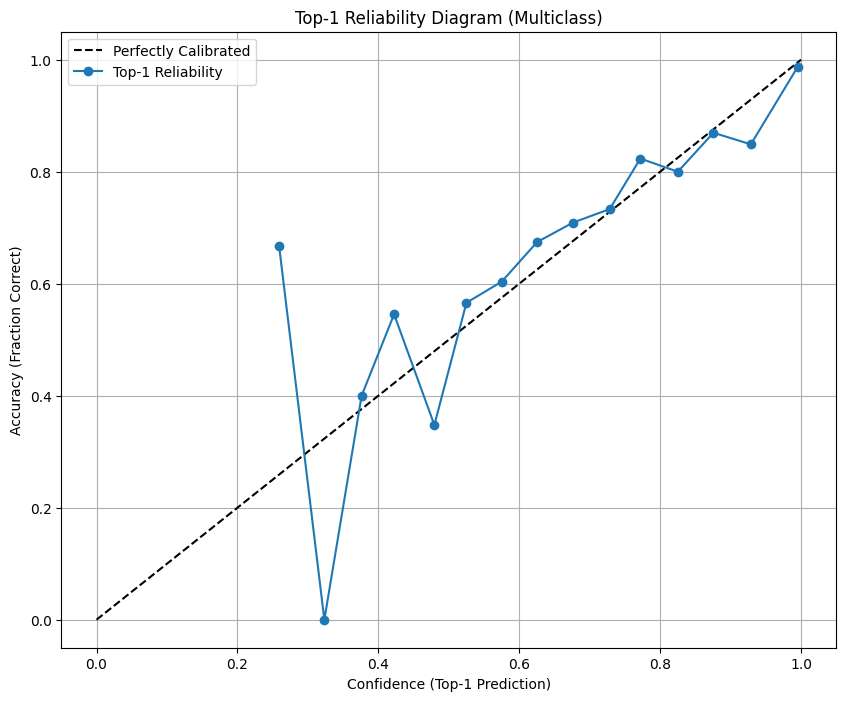

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:585: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


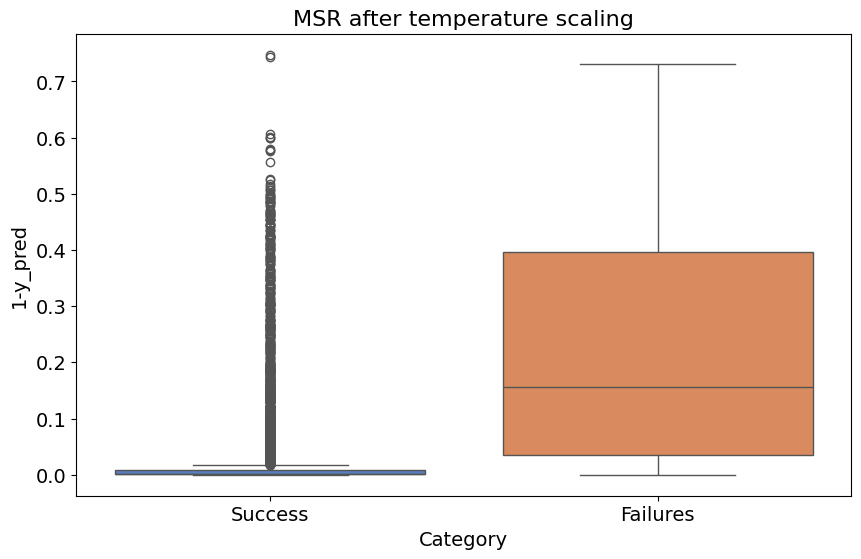

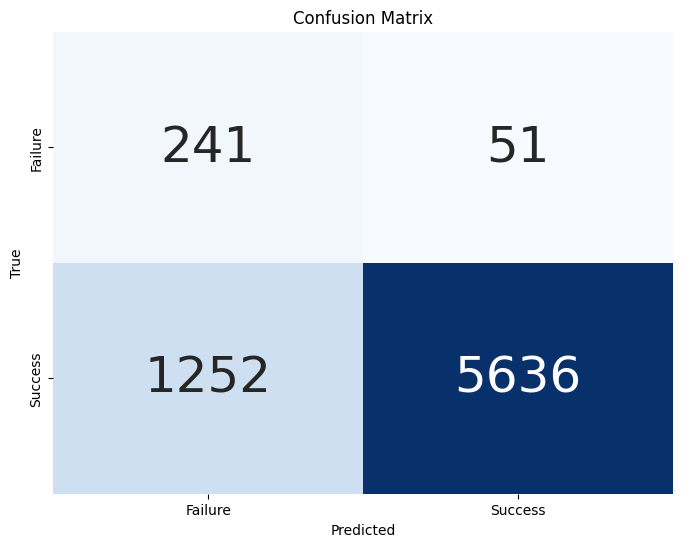

Optimal Threshold: 0.01496955007314682
Balanced Accuracy: 0.8217885383354813
Specificity: 0.8253424657534246
Sensitivity: 0.8182346109175378
0.8754499586336373
Processing bloodmnist with color=True and activation=softmax
Training dataset size: 10936
Calibration dataset size: 2735
Training dataset size: 10936
Calibration dataset size: 2735


/tmp/ipykernel_3550362/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.999, Ensemble Accuracy: 0.989


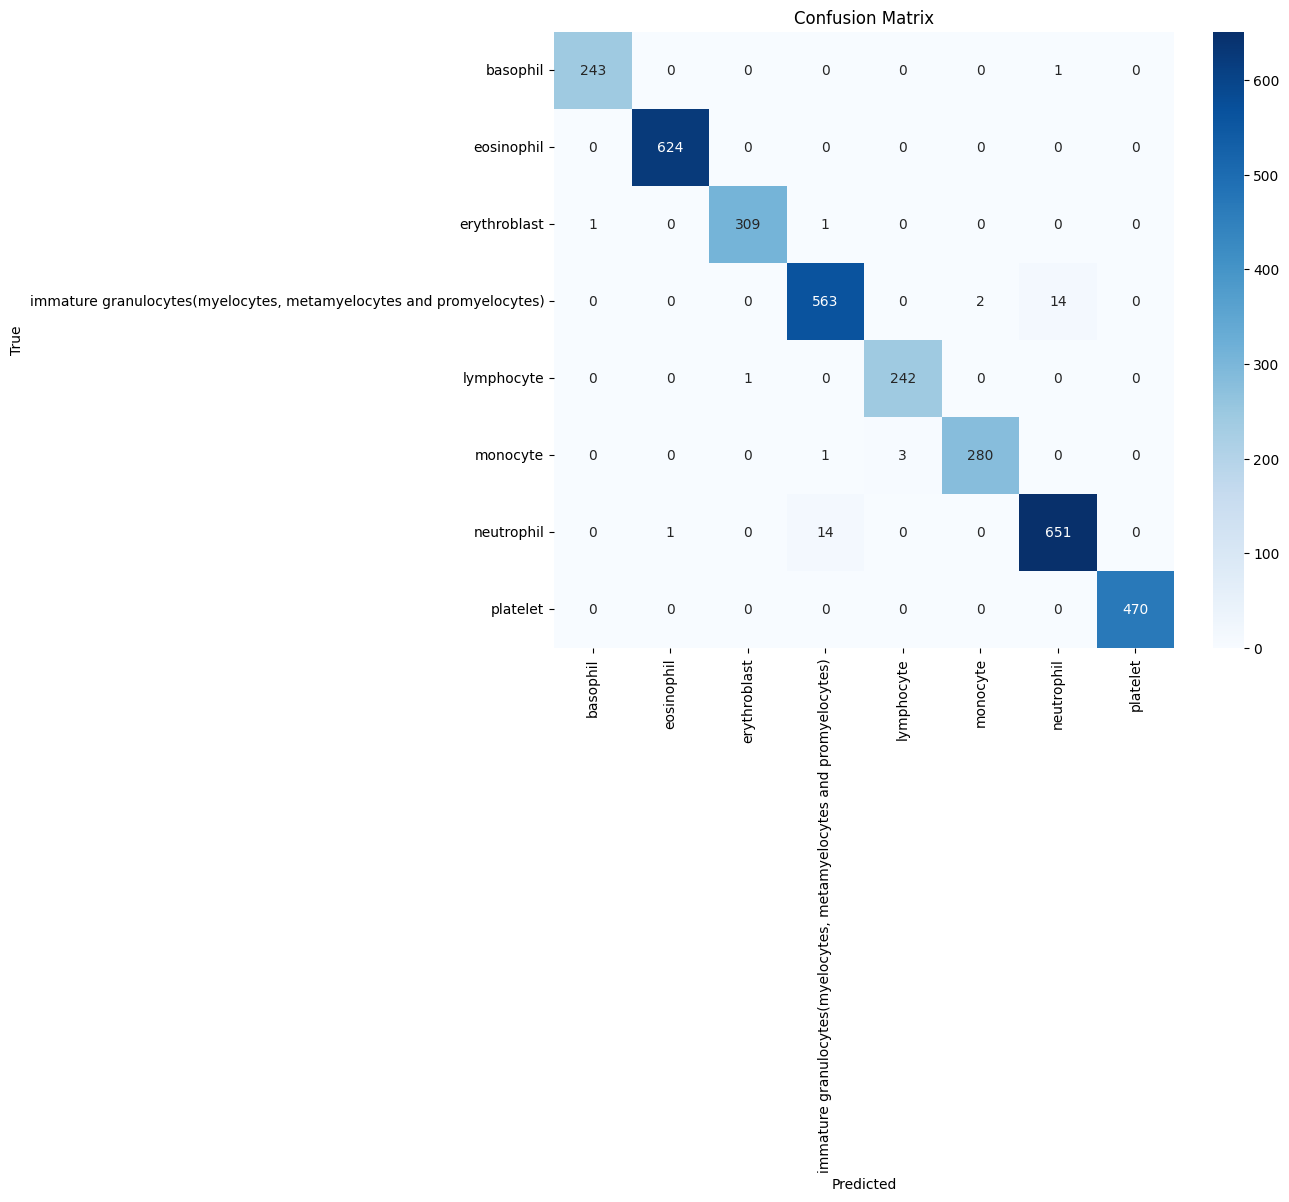

{'auc': np.float64(0.9991616129060517), 'accuracy': 0.9885998246126864, 'balanced_accuracy': np.float64(0.9901393329758483), 'sensitivity': 0.9901393329758483, 'specificity': np.float64(0.9982937677930717), 'confusion_matrix': array([[243,   0,   0,   0,   0,   0,   1,   0],
       [  0, 624,   0,   0,   0,   0,   0,   0],
       [  1,   0, 309,   1,   0,   0,   0,   0],
       [  0,   0,   0, 563,   0,   2,  14,   0],
       [  0,   0,   1,   0, 242,   0,   0,   0],
       [  0,   0,   0,   1,   3, 280,   0,   0],
       [  0,   1,   0,  14,   0,   0, 651,   0],
       [  0,   0,   0,   0,   0,   0,   0, 470]])}


/tmp/ipykernel_3550362/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.999, Ensemble Accuracy: 0.982


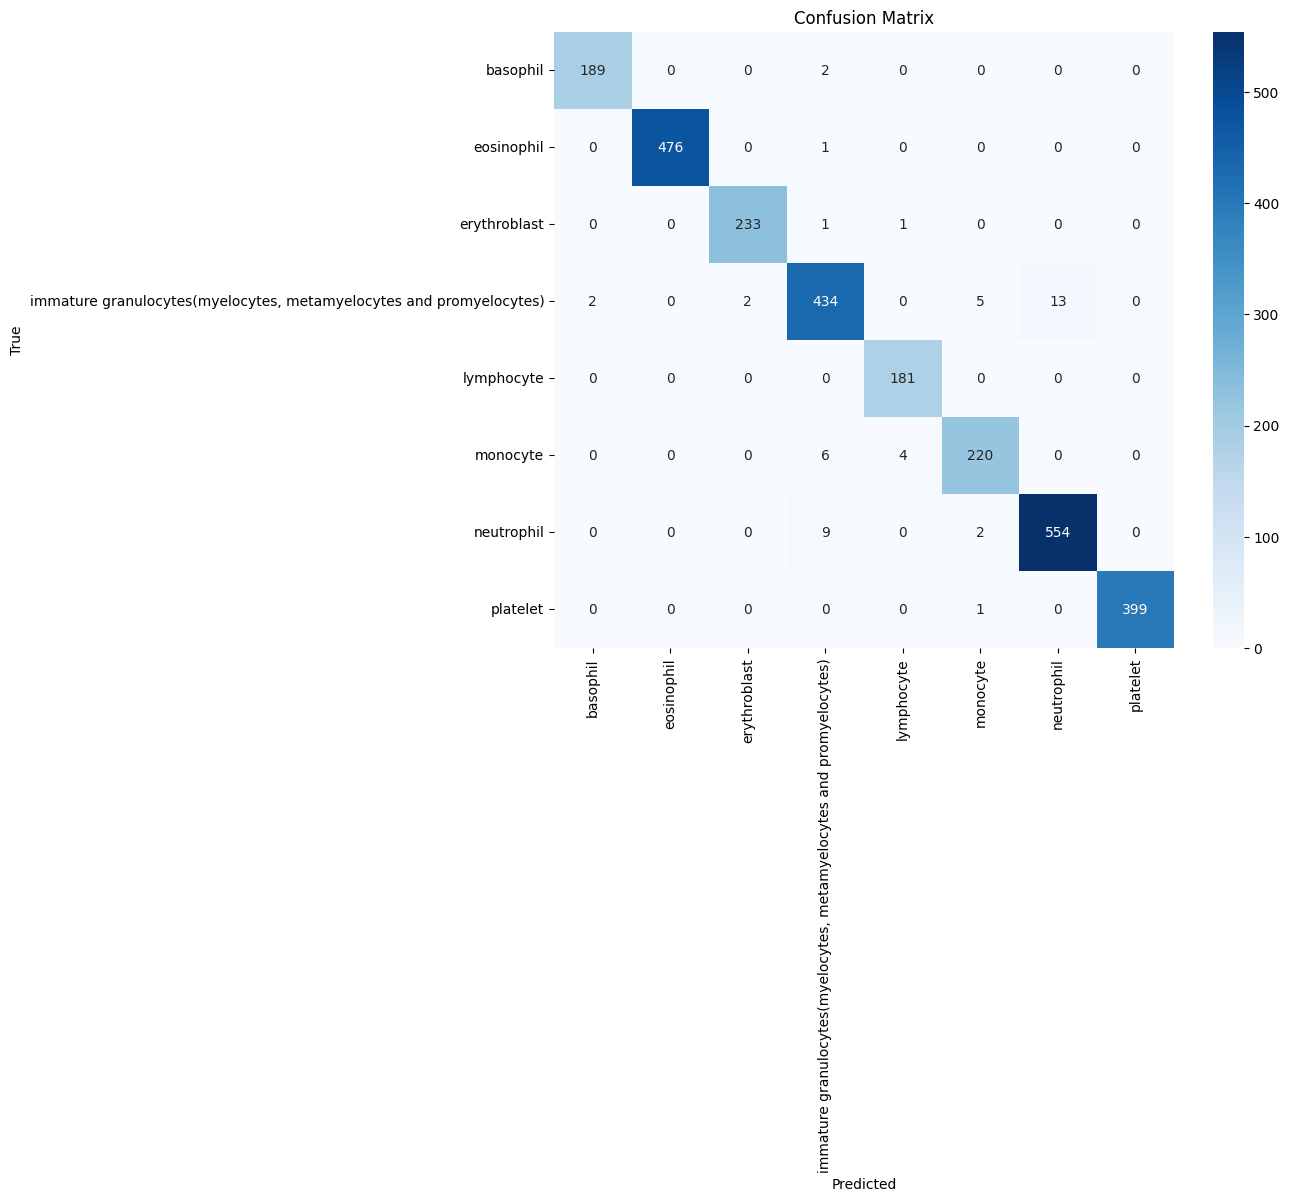

{'auc': np.float64(0.9991197391285711), 'accuracy': 0.9820840950639854, 'balanced_accuracy': np.float64(0.9831536025002026), 'sensitivity': 0.9831536025002026, 'specificity': np.float64(0.997366842124348), 'confusion_matrix': array([[189,   0,   0,   2,   0,   0,   0,   0],
       [  0, 476,   0,   1,   0,   0,   0,   0],
       [  0,   0, 233,   1,   1,   0,   0,   0],
       [  2,   0,   2, 434,   0,   5,  13,   0],
       [  0,   0,   0,   0, 181,   0,   0,   0],
       [  0,   0,   0,   6,   4, 220,   0,   0],
       [  0,   0,   0,   9,   0,   2, 554,   0],
       [  0,   0,   0,   0,   0,   1,   0, 399]])}


/tmp/ipykernel_3550362/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


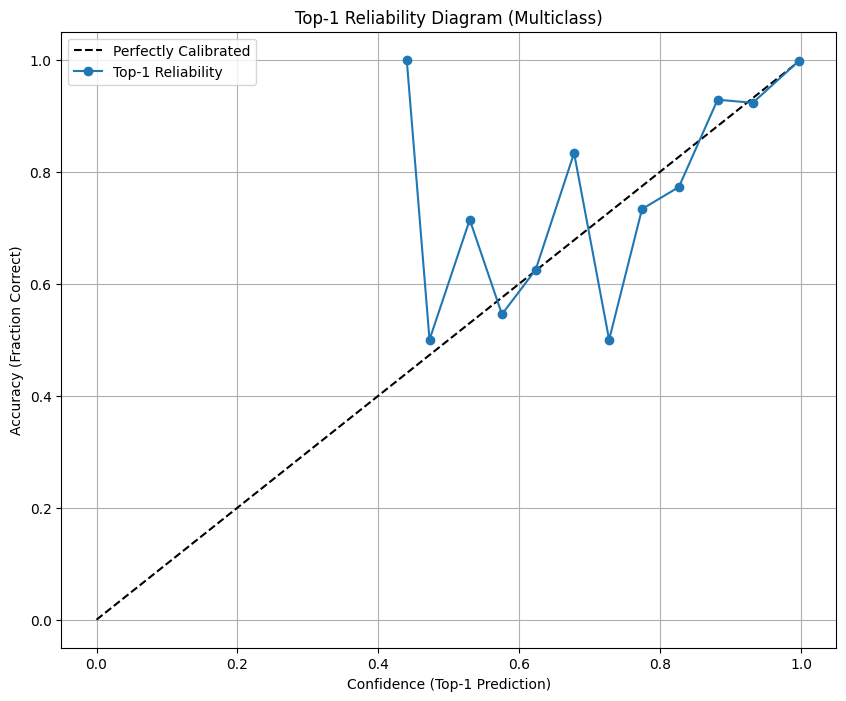

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:585: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


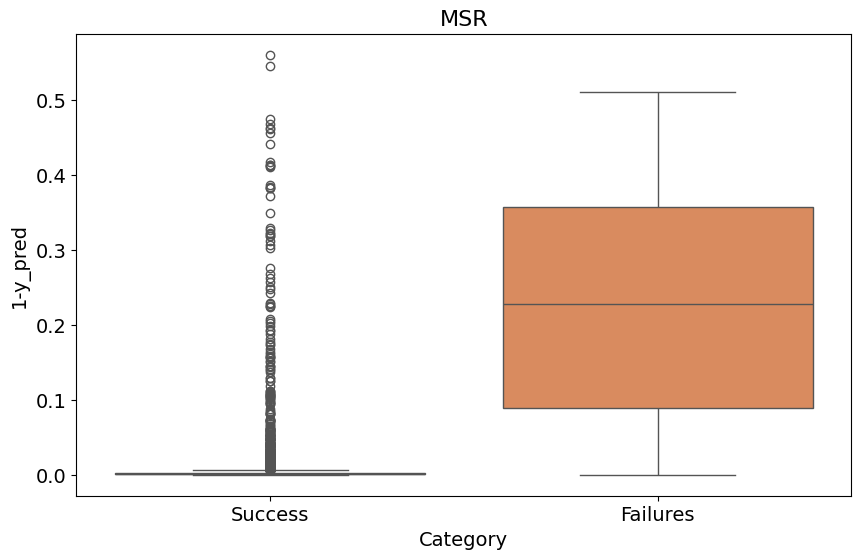

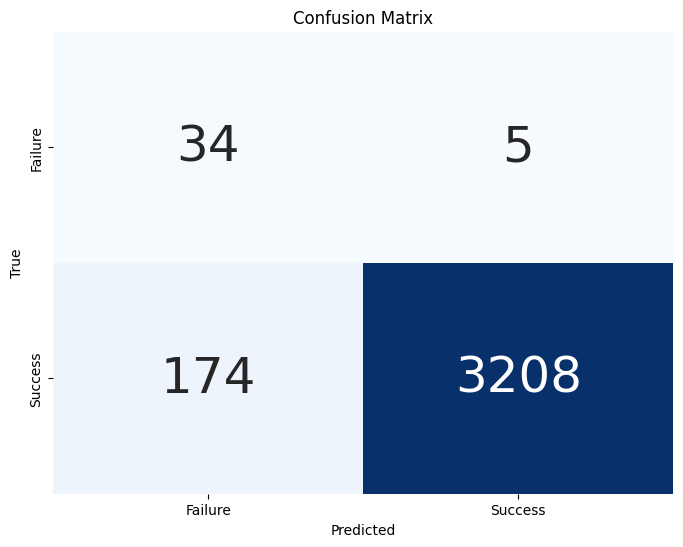

Optimal Threshold: 0.03417586535215378
Balanced Accuracy: 0.9101730124793401
Specificity: 0.8717948717948718
Sensitivity: 0.9485511531638084
0.9126067112465692
Initial log-temperature: 0.4055
Initial temperature: 1.5000
Optimized log-temperature: 0.2011
Optimized temperature: 1.2228
Brier Score Loss (temperature): 0.0052


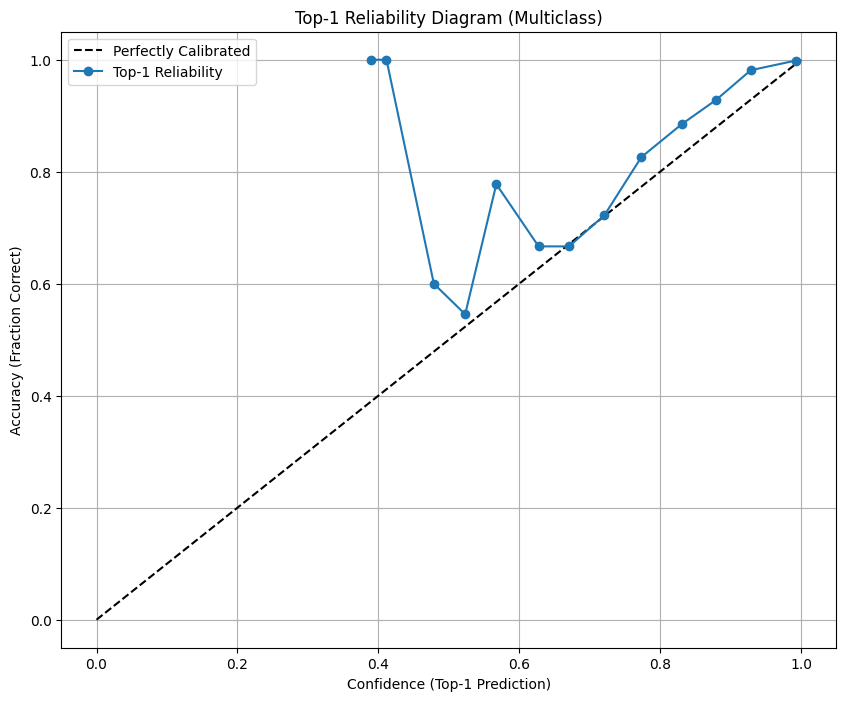

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:585: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


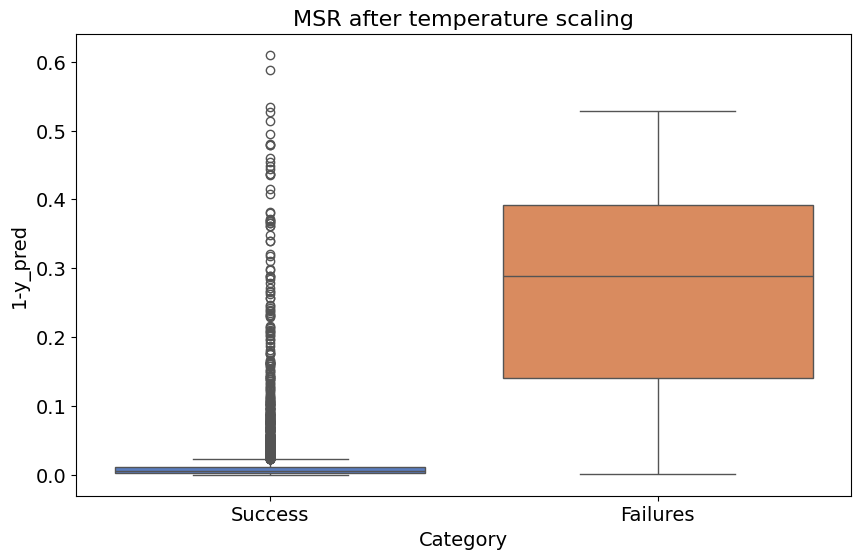

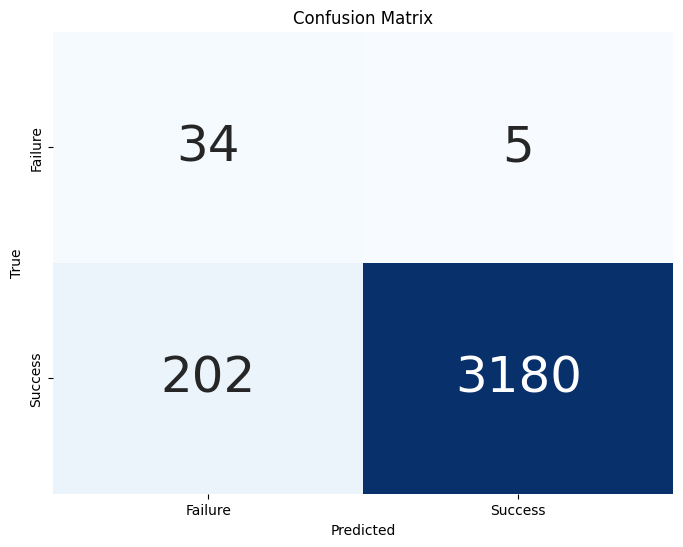

Optimal Threshold: 0.05987309291958809
Balanced Accuracy: 0.9060334500902212
Specificity: 0.8717948717948718
Sensitivity: 0.9402720283855707
0.9116097287297761
Processing tissuemnist with color=False and activation=softmax
Training dataset size: 151284
Calibration dataset size: 37822
Training dataset size: 151284
Calibration dataset size: 37822


/tmp/ipykernel_3550362/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.947, Ensemble Accuracy: 0.724


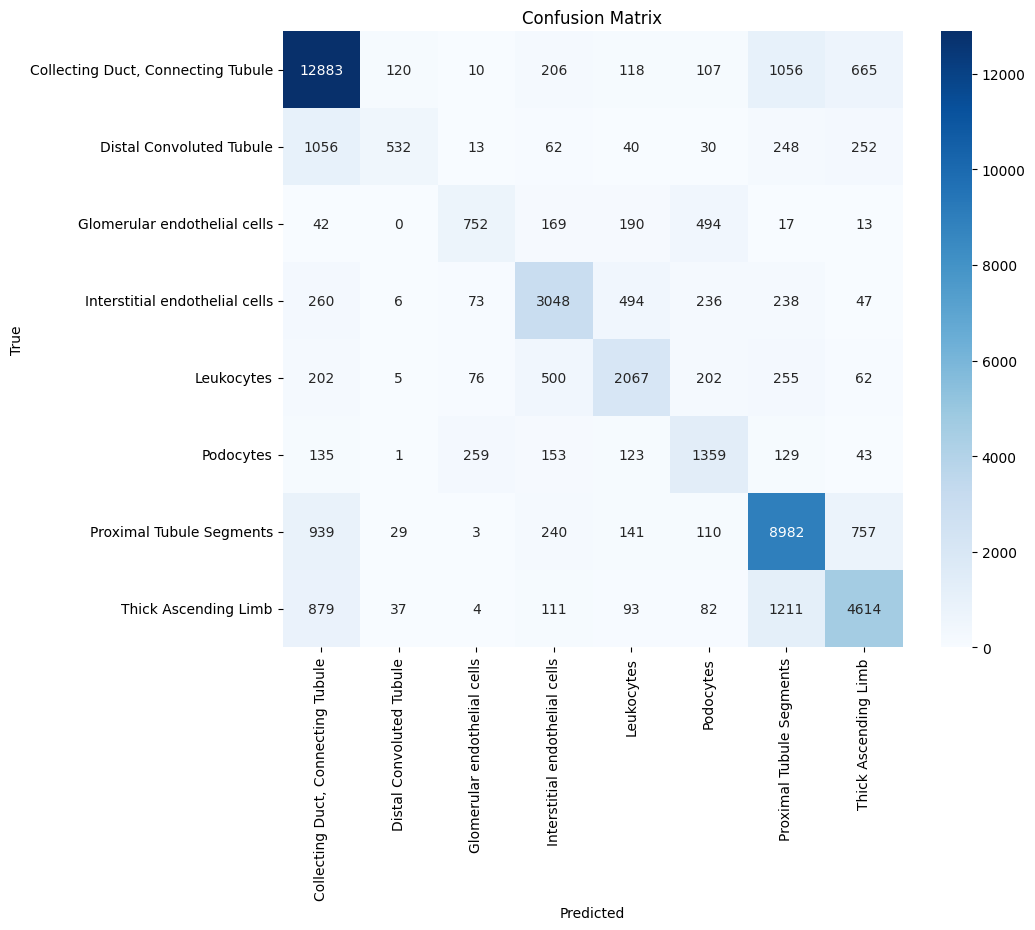

{'auc': np.float64(0.9468476360660238), 'accuracy': 0.7241328257191202, 'balanced_accuracy': np.float64(0.6146786896407591), 'sensitivity': 0.6146786896407591, 'specificity': np.float64(0.956827003647414), 'confusion_matrix': array([[12883,   120,    10,   206,   118,   107,  1056,   665],
       [ 1056,   532,    13,    62,    40,    30,   248,   252],
       [   42,     0,   752,   169,   190,   494,    17,    13],
       [  260,     6,    73,  3048,   494,   236,   238,    47],
       [  202,     5,    76,   500,  2067,   202,   255,    62],
       [  135,     1,   259,   153,   123,  1359,   129,    43],
       [  939,    29,     3,   240,   141,   110,  8982,   757],
       [  879,    37,     4,   111,    93,    82,  1211,  4614]])}


/tmp/ipykernel_3550362/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.948, Ensemble Accuracy: 0.729


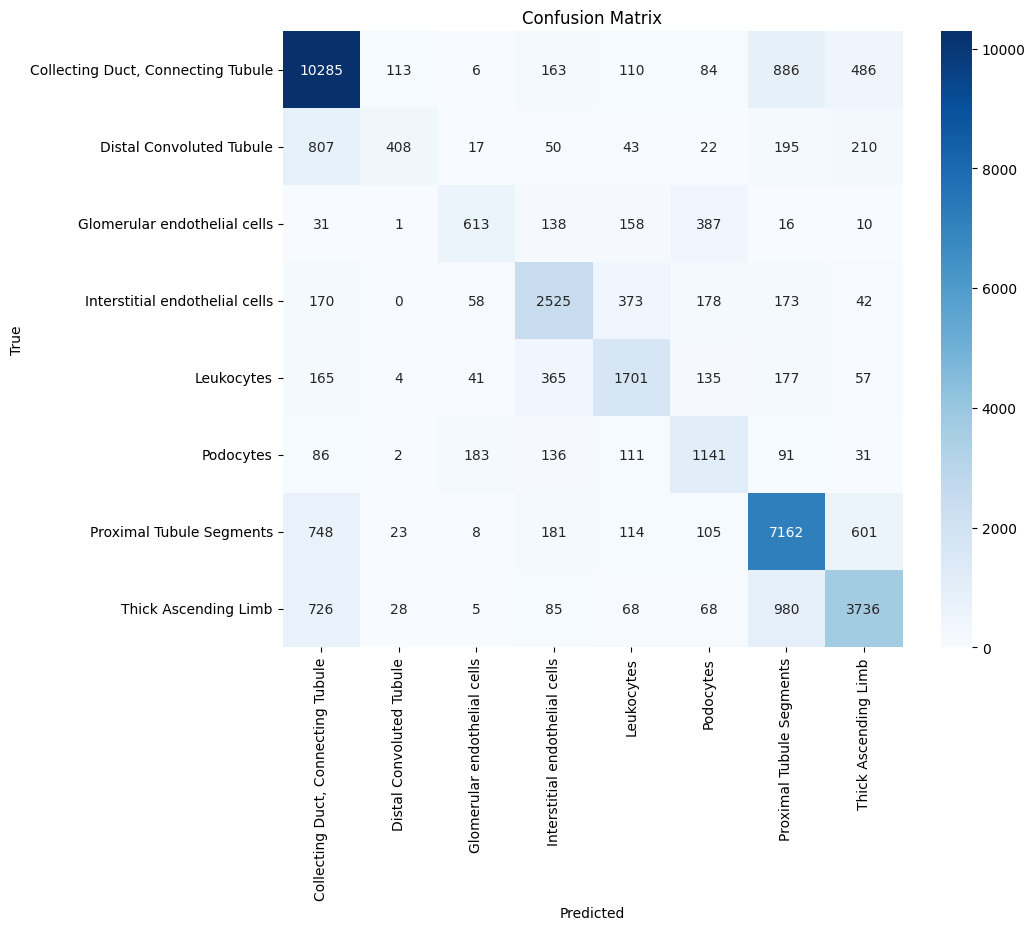

{'auc': np.float64(0.9477218371317908), 'accuracy': 0.7289672677277775, 'balanced_accuracy': np.float64(0.6239275802374751), 'sensitivity': 0.6239275802374751, 'specificity': np.float64(0.95758794578481), 'confusion_matrix': array([[10285,   113,     6,   163,   110,    84,   886,   486],
       [  807,   408,    17,    50,    43,    22,   195,   210],
       [   31,     1,   613,   138,   158,   387,    16,    10],
       [  170,     0,    58,  2525,   373,   178,   173,    42],
       [  165,     4,    41,   365,  1701,   135,   177,    57],
       [   86,     2,   183,   136,   111,  1141,    91,    31],
       [  748,    23,     8,   181,   114,   105,  7162,   601],
       [  726,    28,     5,    85,    68,    68,   980,  3736]])}


/tmp/ipykernel_3550362/3830283869.py:105: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


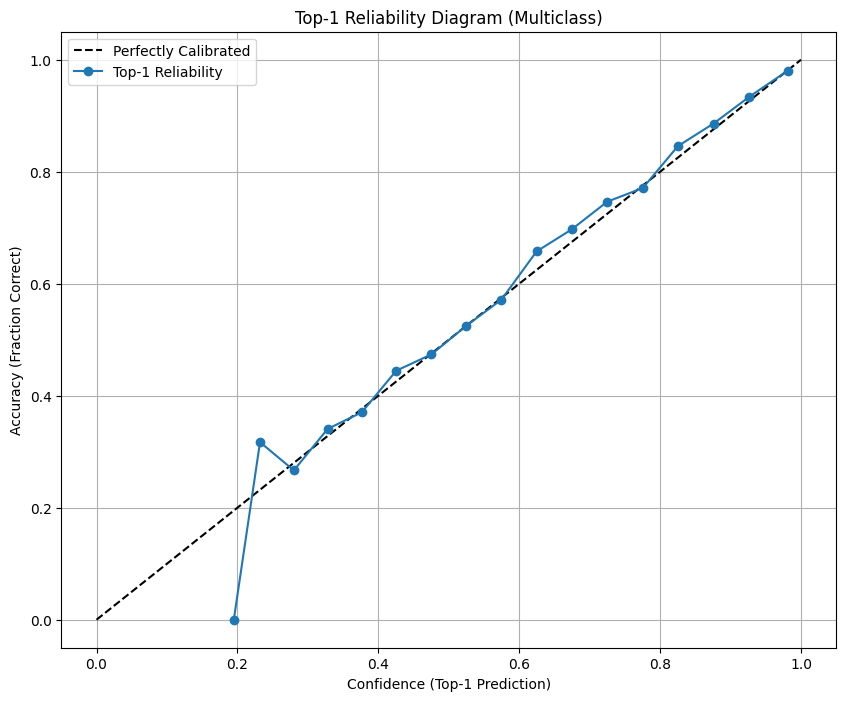

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:585: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


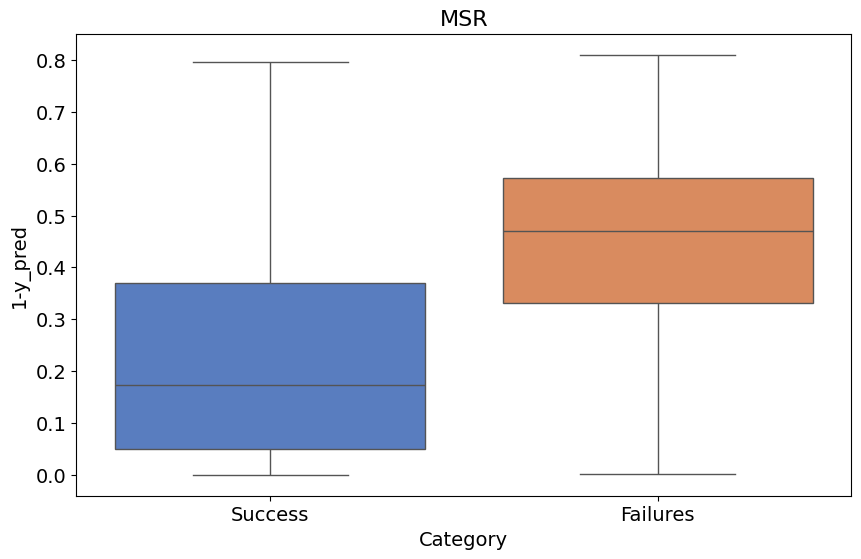

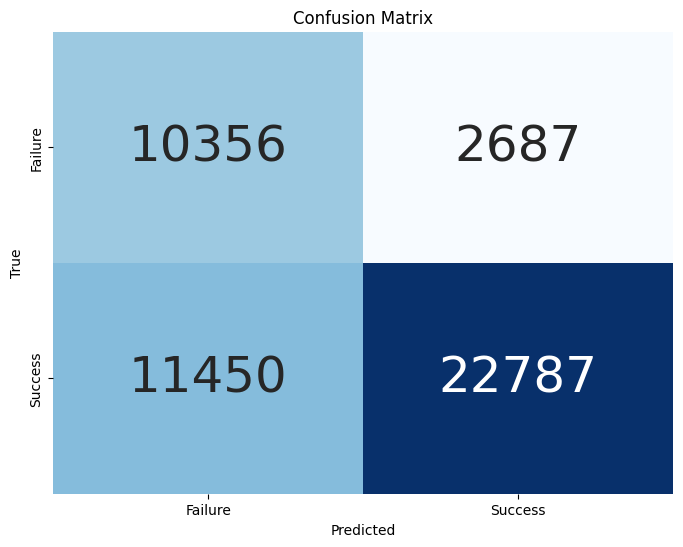

Optimal Threshold: 0.2960062623023987
Balanced Accuracy: 0.7297778026627068
Specificity: 0.7939891129341409
Sensitivity: 0.6655664923912726
0.8006083400711831
Initial log-temperature: 0.4055
Initial temperature: 1.5000
Optimized log-temperature: 0.2135
Optimized temperature: 1.2380
Brier Score Loss (temperature): 0.1013


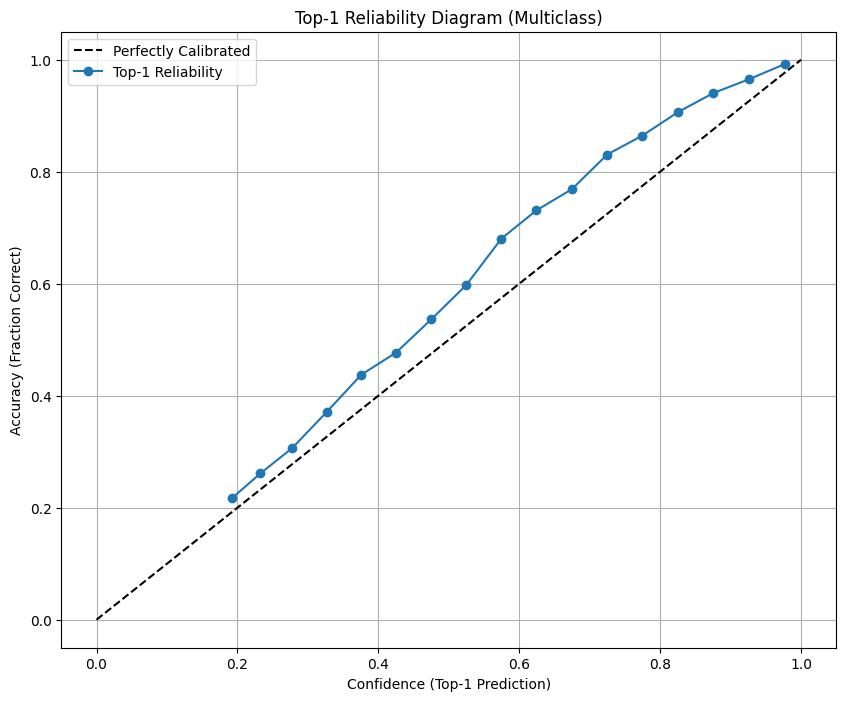

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:585: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


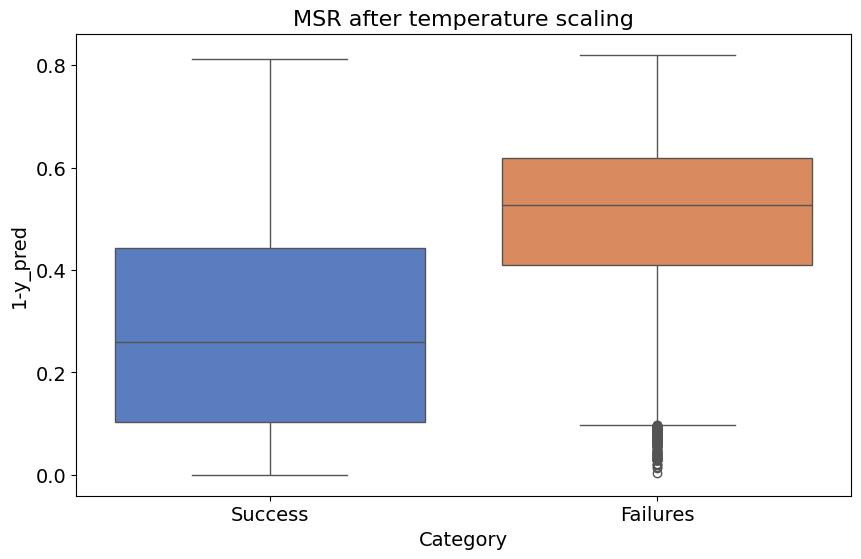

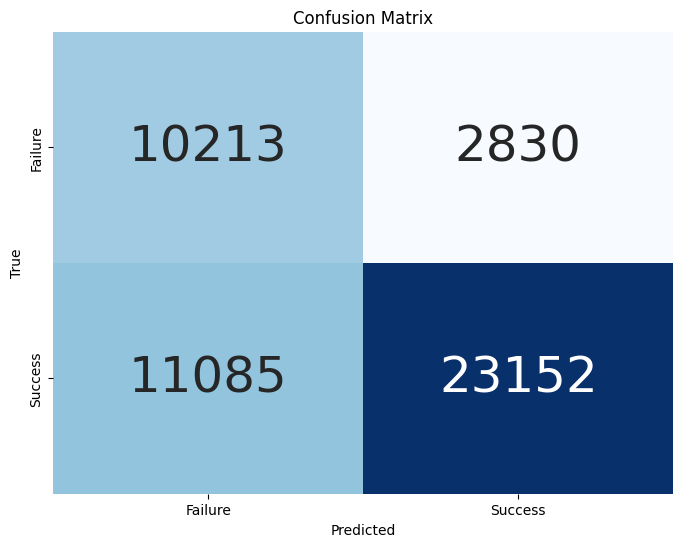

Optimal Threshold: 0.387874037027359
Balanced Accuracy: 0.7296264253993429
Specificity: 0.7830253775971786
Sensitivity: 0.6762274732015071
0.8000833029541602


In [10]:
flags = ['breastmnist', 'organamnist', 'pneumoniamnist', 'dermamnist', 'octmnist', 'pathmnist', 'bloodmnist', 'tissuemnist']
calib_method = ['platt', 'temperature', 'platt', 'temperature', 'temperature', 'temperature', 'temperature', 'temperature']
colors = [False, False, False, True, False, True, True, False]  # Colors for the flags
activations = ['sigmoid', 'softmax', 'sigmoid', 'softmax', 'softmax', 'softmax', 'softmax', 'softmax']  # Output activations for each flag
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
uq_methods = ['MSR', 'MSR_temp_scale']#, 'Ensembling']#, 'TTA', 'GPS', 'KNNshap', 'KNNall']  
size = 224  # Image size for the models
batch_size = 4000  # Batch size for the DataLoader
model_global_perfs = {}

for flag, color, activation, calib_method in zip(flags, colors, activations, calib_method):
    print(f"Processing {flag} with color={color} and activation={activation}")
    if color is True:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
        ])
        
        transform_for_tta = transforms.Compose([
            transforms.ToTensor()
        ])
    else:
        # For grayscale images, repeat the single channel to make it compatible with ResNet
        # ResNet expects 3 channels, so we repeat the single channel image
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.5], std=[.5]),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1))
        ])
        
        transform_tta = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1))
            ])
    models = tr.load_models(flag, device=device)
    [train_dataset, calibration_dataset, test_dataset], [train_loader, calibration_loader, test_loader], info = tr.load_datasets(flag, color, size, transform, batch_size)
    train_loaders, val_loaders = train_val_loaders(train_dataset, batch_size=batch_size)
    task_type = info['task']  # Determine the task type (binary-class or multi-class)
    num_classes = len(info['label'])  # Number of classes
    [_, calibration_dataset_tta, test_dataset_tta], [_, calibration_loader_tta, test_loader_tta], _ = tr.load_datasets(flag, color, size, transform_tta, batch_size)

    y_true, y_scores, digits, indiv_scores, performances = test_eval(test_loader, device=device, models=models, data_flag=flag)
    y_true_calibration, y_scores_calibration, digits_calib, indiv_scores_calib, performances_calib = test_eval(calibration_loader, device=device, models=models, data_flag=flag)

    if task_type == 'binary-class':
        y_prob = y_scores
        y_prob_calibration = y_scores_calibration
    else:
        y_prob = apply_softmax(y_scores)
        y_prob_calibration = apply_softmax(y_scores_calibration)

    if task_type == 'binary-class':
        correct_predictions = [i for i in range(len(y_true)) if (y_true[i] == 1 and y_scores[i] > 0.5) or (y_true[i] == 0 and y_scores[i] <= 0.5)]
        incorrect_predictions = [i for i in range(len(y_true)) if (y_true[i] == 1 and y_scores[i] <= 0.5) or (y_true[i] == 0 and y_scores[i] > 0.5)]

        correct_predictions_calibration = [i for i in range(len(y_true_calibration)) if (y_true_calibration[i] == 1 and y_scores_calibration[i] > 0.5) or (y_true_calibration[i] == 0 and y_scores_calibration[i] <= 0.5)]
        incorrect_predictions_calibration = [i for i in range(len(y_true_calibration)) if (y_true_calibration[i] == 1 and y_scores_calibration[i] <= 0.5) or (y_true_calibration[i] == 0 and y_scores_calibration[i] > 0.5)]
    else:
        correct_predictions = [i for i in range(len(y_true)) if y_true[i] == np.argmax(y_scores[i])]
        incorrect_predictions = [i for i in range(len(y_true)) if y_true[i] != np.argmax(y_scores[i])]

        correct_predictions_calibration = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] == np.argmax(y_scores_calibration[i])]
        incorrect_predictions_calibration = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] != np.argmax(y_scores_calibration[i])]

    uq_metrics, aucs = call_UQ_methods(uq_methods, models, y_prob, digits, y_true, digits_calib, y_true_calibration, indiv_scores, task_type, correct_predictions, incorrect_predictions, test_loader, device, optim_metric='balanced_accuracy', train_loaders=train_loaders, test_loader_tta=test_loader_tta, num_classes=num_classes, image_normalization=True, swarmplot=False, calib_method=calib_method)
    model_global_perfs[flag] = {}
    model_global_perfs[flag]['class_perf'] = performances
    model_global_perfs[flag]['calibration_size'] = len(calibration_dataset)
    model_global_perfs[flag]['uq_metrics'] = uq_metrics
    model_global_perfs[flag]['aucs_UQ'] = aucs
    #break

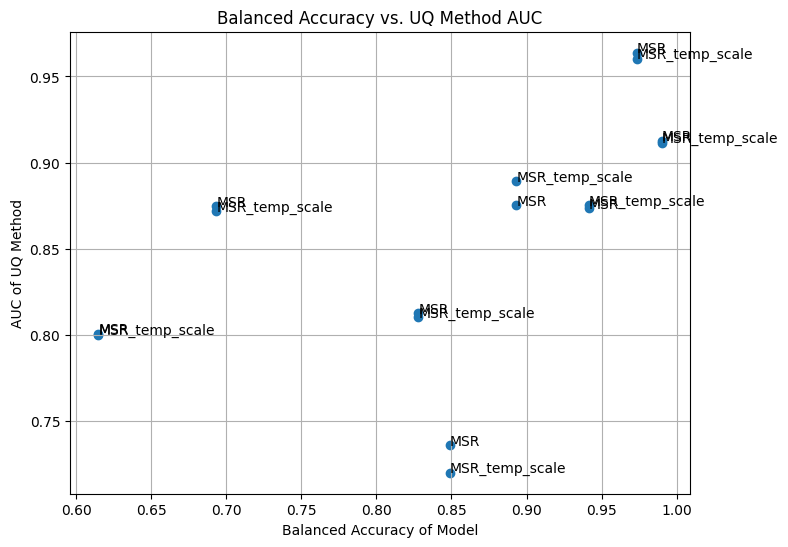

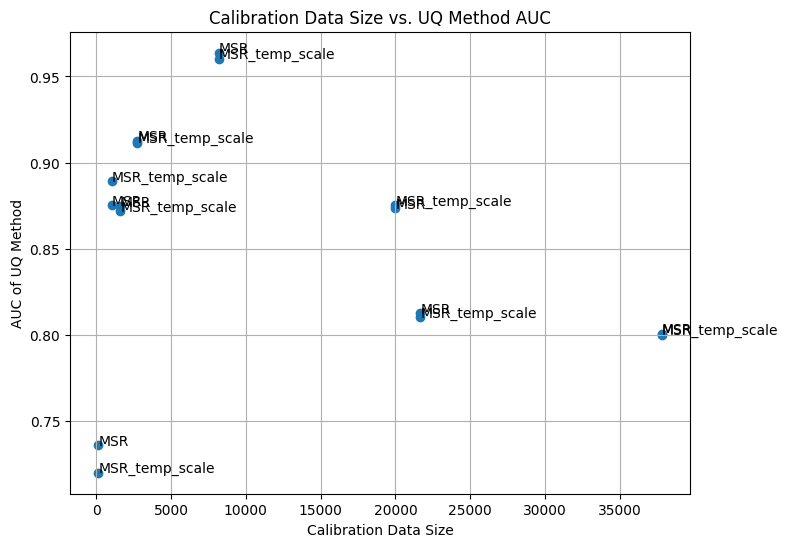

In [11]:
# Flatten the lists so that each argument is a flat list
perf_dicts = [model_global_perfs[flag]['class_perf'] for flag in flags for _ in range(len(model_global_perfs[flag]['aucs_UQ']))]
aucs = [model_global_perfs[flag]['aucs_UQ'][i][1] for flag in flags for i in range(len(model_global_perfs[flag]['aucs_UQ']))]
calibration_sizes = [model_global_perfs[flag]['calibration_size'] for flag in flags for _ in range(len(model_global_perfs[flag]['aucs_UQ']))]
uq_methods_names = [model_global_perfs[flag]['aucs_UQ'][i][0] for flag in flags for i in range(len(model_global_perfs[flag]['aucs_UQ']))]

plot_perf_vs_uq_auc(
    perf_dicts,
    aucs,
    calibration_sizes,
    uq_methods_names=uq_methods_names
)

In [ ]:
class ClassifierHeadWrapper(nn.Module):
    def __init__(self, model):
        super(ClassifierHeadWrapper, self).__init__()
        self.fc = model.fc  # Replace 'fc2' with the appropriate layer name

    def forward(self, x):
        return self.fc(x)

In [ ]:
# #Load the SHAP results from the pickle file
# with open('shap_results_calibration.pkl', 'rb') as file:
#     shap_results_calibration = pkl.load(file)

In [ ]:
# #Load the SHAP results from the pickle file
# with open('shap_results.pkl', 'rb') as file:
#     shap_results_test = pkl.load(file)

In [ ]:
models = [model.to(device) for model in models]
latent_spaces = []
shap_values_folds = []
success_folds = []
labels_fold = []
for fold in range(0, 5):
    print('fold n' + str(fold))
    classifier_head = ClassifierHeadWrapper(models[fold]).to(device)
    # Compute SHAP values for the penultimate layer
    shap_values, shap_features, labels, success = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=calibration_loader,
        device=device,
        layer_to_be_hooked=models[fold].avgpool,
        classifierheadwrapper=classifier_head,
        importance=True,
        max_background_samples=125
    )
    latent_spaces.append(shap_features)
    shap_values_folds.append(shap_values)
    success_folds.append(success.squeeze() if success.ndim > 1 else success)
    labels_fold.append(labels.squeeze() if labels.ndim > 1 else labels)

In [ ]:
models = [model.to(device) for model in models]
latent_spaces_calibration = []
shap_values_folds_calibration = []
success_folds_calibration = []
labels_fold_calibration = []
for fold in range(0, 5):
    print('fold n' + str(fold))
    classifier_head = ClassifierHeadWrapper(models[fold]).to(device)
    # Compute SHAP values for the penultimate layer
    shap_values, shap_features, labels, success = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=test_loader,
        device=device,
        layer_to_be_hooked=models[fold].avgpool,
        classifierheadwrapper=classifier_head,
        importance=True,
        max_background_samples=156
    )
    latent_spaces_calibration.append(shap_features)
    shap_values_folds_calibration.append(shap_values)
    success_folds_calibration.append(success.squeeze() if success.ndim > 1 else success)
    labels_fold_calibration.append(labels.squeeze() if labels.ndim > 1 else labels)

In [ ]:
uq_methods = ['MSR', 'MSR_temp_scale', 'Ensembling', 'TTA', 'GPS', 'KNNshap', 'KNNall']

In [ ]:
# for fold in range(5):
#     print(fold)
#     latent_space_training, labels_train, flags_train, _ = uq.extract_latent_space_and_compute_shap_importance(
#         model=models[fold],
#         data_loader=train_loaders[fold],
#         device=device,
#         layer_to_be_hooked=models[fold].avgpool,
#         importance=False
#     )
    
#     latent_space_test, labels_test, flags_test, _ = uq.extract_latent_space_and_compute_shap_importance(
#         model=models[fold],
#         data_loader=test_loader,
#         device=device,
#         layer_to_be_hooked=models[fold].avgpool,
#         importance=False
#     )
    
#     train_latent_space = pd.DataFrame(latent_space_training)
#     test_latent_space = pd.DataFrame(latent_space_test)
        
#     # Print the initial number of dimensions
#     print(f"Initial number of dimensions: {train_latent_space.shape[1]}")
        
#     scaler = StandardScaler()
#     train_latent_space_standardized = scaler.fit_transform(train_latent_space)
#     # Apply UMAP for dimensionality reduction to 2D
#     umap_reducer = umap.UMAP(n_components=2, random_state=42)
#     train_latent_space_umap = umap_reducer.fit_transform(train_latent_space_standardized)
#     test_latent_space_umap = umap_reducer.transform(scaler.transform(test_latent_space))

#     # Print the reduced dimensions
#     print(f"Reduced dimensions (train): {train_latent_space_umap.shape}")
#     print(f"Reduced dimensions (test): {test_latent_space_umap.shape}")
    
#     uq.visualize_umap_with_labels(train_latent_space_umap, test_latent_space_umap, flags_test, labels_train, fold)

In [ ]:
uq_metrics = call_UQ_methods(uq_methods, models, y_prob, digits, y_true, digits_calib, y_true_calibration, indiv_scores, task_type, correct_predictions, incorrect_predictions, test_loader, device, optim_metric='balanced_accuracy', train_loaders=train_loaders, test_loader_tta=test_loader_tta, num_classes=2, latent_spaces=latent_spaces, shap_values_folds=shap_values_folds, labels_fold=labels_fold, correct_predictions_calibration=correct_predictions_calibration, incorrect_predictions_calibration=incorrect_predictions_calibration, image_normalization=True, aug_folder='gps_augment_breastmnist', swarmplot=True)

In [ ]:
uq_metrics_calibration = call_UQ_methods(uq_methods, models, y_prob_calibration, digits_calib, y_true_calibration, digits, y_true, indiv_scores_calib, task_type, correct_predictions_calibration, incorrect_predictions_calibration, calibration_loader, device, optim_metric='balanced_accuracy', train_loaders=train_loaders, test_loader_tta=calibration_loader_tta, num_classes=2, latent_spaces=latent_spaces_calibration, shap_values_folds=shap_values_folds_calibration, labels_fold=labels_fold_calibration, correct_predictions_calibration=correct_predictions, incorrect_predictions_calibration=incorrect_predictions, image_normalization=True, aug_folder='gps_augment_breastmnist_testset', swarmplot=True)

In [ ]:
display_UQ_results(uq_metrics[5][1], correct_predictions, incorrect_predictions, 'std', 'TTA', optim_metric='specificity', swarmplot=True)

In [ ]:
display_UQ_results(uq_metrics[4][1], correct_predictions, incorrect_predictions, 'Mean(Zscore(UQ metrics))', 'UQ methods combination', optim_metric='specificity', swarmplot=True)

In [ ]:
mean_values = uq.standardize_and_ensemble(
	np.column_stack(
		[uq_metrics[i][1] for i in range(len(uq_metrics)) if uq_metrics[i][0] in ['MSR_temp_scale', 'Ensembling', 'GPS', 'KNNall']]
	), 'mean'
)
min_values = uq.standardize_and_ensemble(
	np.column_stack(
		[uq_metrics[i][1] for i in range(len(uq_metrics)) if uq_metrics[i][0] in ['MSR_temp_scale', 'Ensembling', 'GPS', 'KNNall']]
	), 'min'
)
max_values = uq.standardize_and_ensemble(
    np.column_stack(
        [uq_metrics[i][1] for i in range(len(uq_metrics)) if uq_metrics[i][0] in ['MSR_temp_scale', 'Ensembling', 'GPS', 'KNNall']]
	), 'max'
)

In [ ]:
display_UQ_results(mean_values, correct_predictions, incorrect_predictions, 'Mean(Zscore(UQ metrics))', 'UQ methods combination', optim_metric='specificity', swarmplot=True)

In [ ]:
display_UQ_results(max_values, correct_predictions, incorrect_predictions, 'Max(Zscore(UQ metrics))', 'UQ methods combination', optim_metric='specificity', swarmplot=True)

In [ ]:
display_UQ_results(min_values, correct_predictions, incorrect_predictions, 'Min(Zscore(UQ metrics))', 'UQ methods combination', optim_metric='specificity', swarmplot=True)

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Prepare the calibration data
X_calibration = np.column_stack([uq_metrics_calibration[i][1] for i in range(len(uq_metrics_calibration)) if uq_metrics_calibration[i][0] in ['MSR_temp_scale', 'Ensembling', 'GPS', 'KNNall']])
y_calibration = np.array([1 if i in correct_predictions_calibration else 0 for i in range(len(uq_metrics_calibration[0][1]))])

class_weights = compute_class_weight('balanced', classes=np.unique(y_calibration), y=y_calibration)
class_weight_dict = {0: class_weights[1], 1: class_weights[0]}

# Prepare the test data
X_test = np.column_stack([uq_metrics[i][1] for i in range(len(uq_metrics)) if uq_metrics[i][0] in ['MSR_temp_scale', 'Ensembling', 'GPS', 'KNNall']])

# Create a perceptron model with a standard scaler
perceptron = make_pipeline(StandardScaler(), Perceptron(class_weight=class_weight_dict))

# Train the perceptron on the calibration data
perceptron.fit(X_calibration, y_calibration)

# Get the scores for all test data
test_scores = perceptron.decision_function(X_test)

# Print the test scores
print(test_scores)

In [ ]:
display_UQ_results(test_scores, correct_predictions, incorrect_predictions, 'Perceptron trained on calibration data', 'UQ methods combination', optim_metric='specificity', swarmplot=True)

In [ ]:
fpr_percep, tpr_percep, auc_percep = uq.roc_curve_UQ_method_computation([test_scores[k] for k in correct_predictions], [test_scores[j] for j in incorrect_predictions])
fpr_mean, tpr_mean, auc_mean = uq.roc_curve_UQ_method_computation([mean_values[k] for k in correct_predictions], [mean_values[j] for j in incorrect_predictions])
fpr_max, tpr_max, auc_max = uq.roc_curve_UQ_method_computation([max_values[k] for k in correct_predictions], [max_values[j] for j in incorrect_predictions])
fpr_min, tpr_min, auc_min = uq.roc_curve_UQ_method_computation([min_values[k] for k in correct_predictions], [min_values[j] for j in incorrect_predictions])

In [ ]:
uq.roc_curve_UQ_methods_plot(['Perceptron', 'Mean', 'Max', 'Min'], [fpr_percep, fpr_mean, fpr_max, fpr_min], [tpr_percep, tpr_mean, tpr_max, tpr_min], [auc_percep, auc_mean, auc_max, auc_min])

In [ ]:
fprs = []
tprs = []
aucs = []
for method in uq_metrics:
    fpr, tpr, auc = uq.roc_curve_UQ_method_computation([method[1][k] for k in correct_predictions], [method[1][j] for j in incorrect_predictions])
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc)

In [ ]:
uq.roc_curve_UQ_methods_plot(uq_methods, fprs, tprs, aucs)